## Overview:

In my method for detecting credit card fraud, I perceive it as a two-category classification problem. Yet, due to the significant disparity in the distribution of data, constructing a suitable decision boundary becomes a complicated task in credit card fraud detection. To navigate this issue, I adopt a systematic procedure.My first step involves examining the distribution of data variables related to fraudulent and legitimate transactions to enrich my comprehension of the data. Following that, I utilize a straightforward statistical model, such as logistic regression, to grasp the impact of various variables on fraudulent transactions. Subsequently, I evolve the model into a more versatile one, applying feature selection methods and reducing the size of the majority class to bolster the model's prowess in fraud prediction. I additionally illustrate the utility of boosting models like Lightgbm in enhancing model performance. Moreover, Shapley values are used to interpret the model's predictions, which deliver valuable insights for the business.

Ultimately, the process culminates in a discussion about the results and practical implications.

Here is a breakdown of the steps included in this notebook:

1. Exploration of Data.
2. Statistical Analysis.
3. Logistic Regression.
4. Recursive Feature Elimination.
5. Downsizing the Majority Class.
6. Complex Model.
7. Explainable AI.
8. Final Remarks, Discussion, and Practical Insights.

In [27]:
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import shap
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import *
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE


import warnings
warnings.filterwarnings('ignore')

##### Reusable Helper Functions:

In [10]:
def get_dataframe_from_summary(est):
    results_summary = est.summary()
    results_as_html = results_summary.tables[1].as_html()
    return pd.read_html(results_as_html, header=0, index_col=0)[0]


def get_regressor_coefficients(model, columns):
    coefficients = {}
    for coefficient, feature in zip(model.coef_, columns):
        coefficients[feature] = coefficient

    return coefficients


def ge_learning_curve(model, x, y, cv, scoring='f1'):
    learning_curve(model, x, y, cv=cv, scoring=scoring)


def get_FeatureImportances(model, X, y):
    viz = FeatureImportances(model)
    viz.fit(X, y)
    viz.show()


def get_ROCAUC(model, x_train, y_train, x_test, y_test, classes):
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()


def get_PrecisionRecallCurve(model, x_train, y_train, x_test, y_test):
    viz = PrecisionRecallCurve(model)
    viz.fit(x_train, y_train)
    viz.score(x_test, y_test)
    viz.show()


def get_ConfusionMatrix(model, x_train, y_train, x_test, y_test):
    cm = ConfusionMatrix(model, classes=["non_fraud", "fraud"])
    cm.fit(x_train, y_train)
    cm.score(x_test, y_test)
    cm.show()


def get_DiscriminationThreshold(model, X, y):
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X, y)
    visualizer.show()


def feature_importance_plot(importances, feature_labels, ax=None):
    importa = pd.DataFrame({"Importance": importances,
                            "Feature": feature_labels})

    importa.sort_values("Importance", inplace=True, ascending=False)
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x="Importance", y="Feature", ax=axis, data=importa)
    axis.set_title('Feature Importance Measures')
    plt.close()

    return axis if ax else fig


####  Data Exploration:

In [11]:
data = pd.read_csv("data/creditcard.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<Axes: title={'center': 'Class Distribution are heavily imbalanced'}>

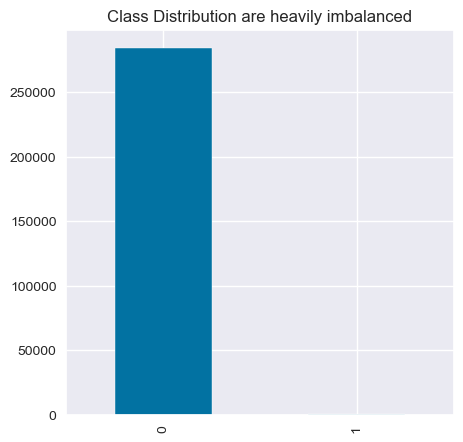

In [12]:
plt.figure(figsize=(5, 5))
data["Class"].value_counts().plot(kind="bar",title="Class Distribution are heavily imbalanced")

<Axes: title={'center': 'Time Distribution '}, ylabel='Frequency'>

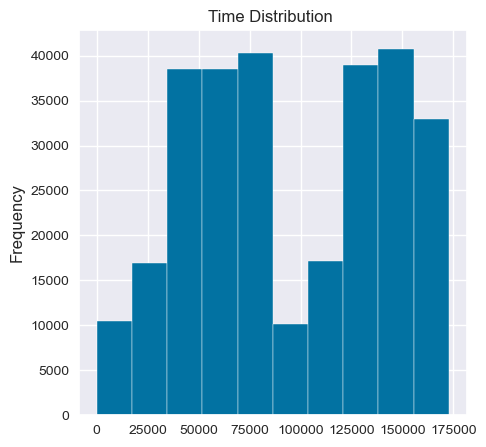

In [13]:
plt.figure(figsize=(5, 5))
data["Time"].plot(kind="hist",title="Time Distribution ")

<Axes: title={'center': 'Amount Distribution Most of the transactions are small'}, ylabel='Frequency'>

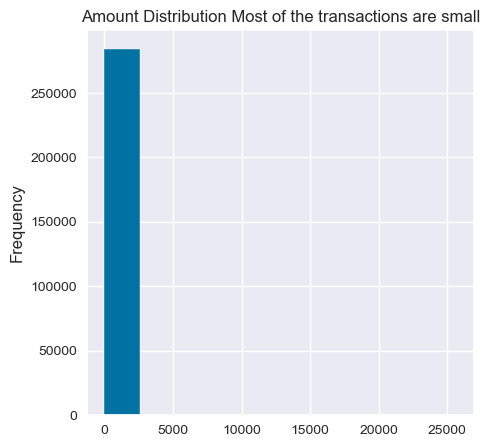

In [14]:
plt.figure(figsize=(5, 5))
data["Amount"].plot(kind="hist",title="Amount Distribution Most of the transactions are small")

###### correlations:

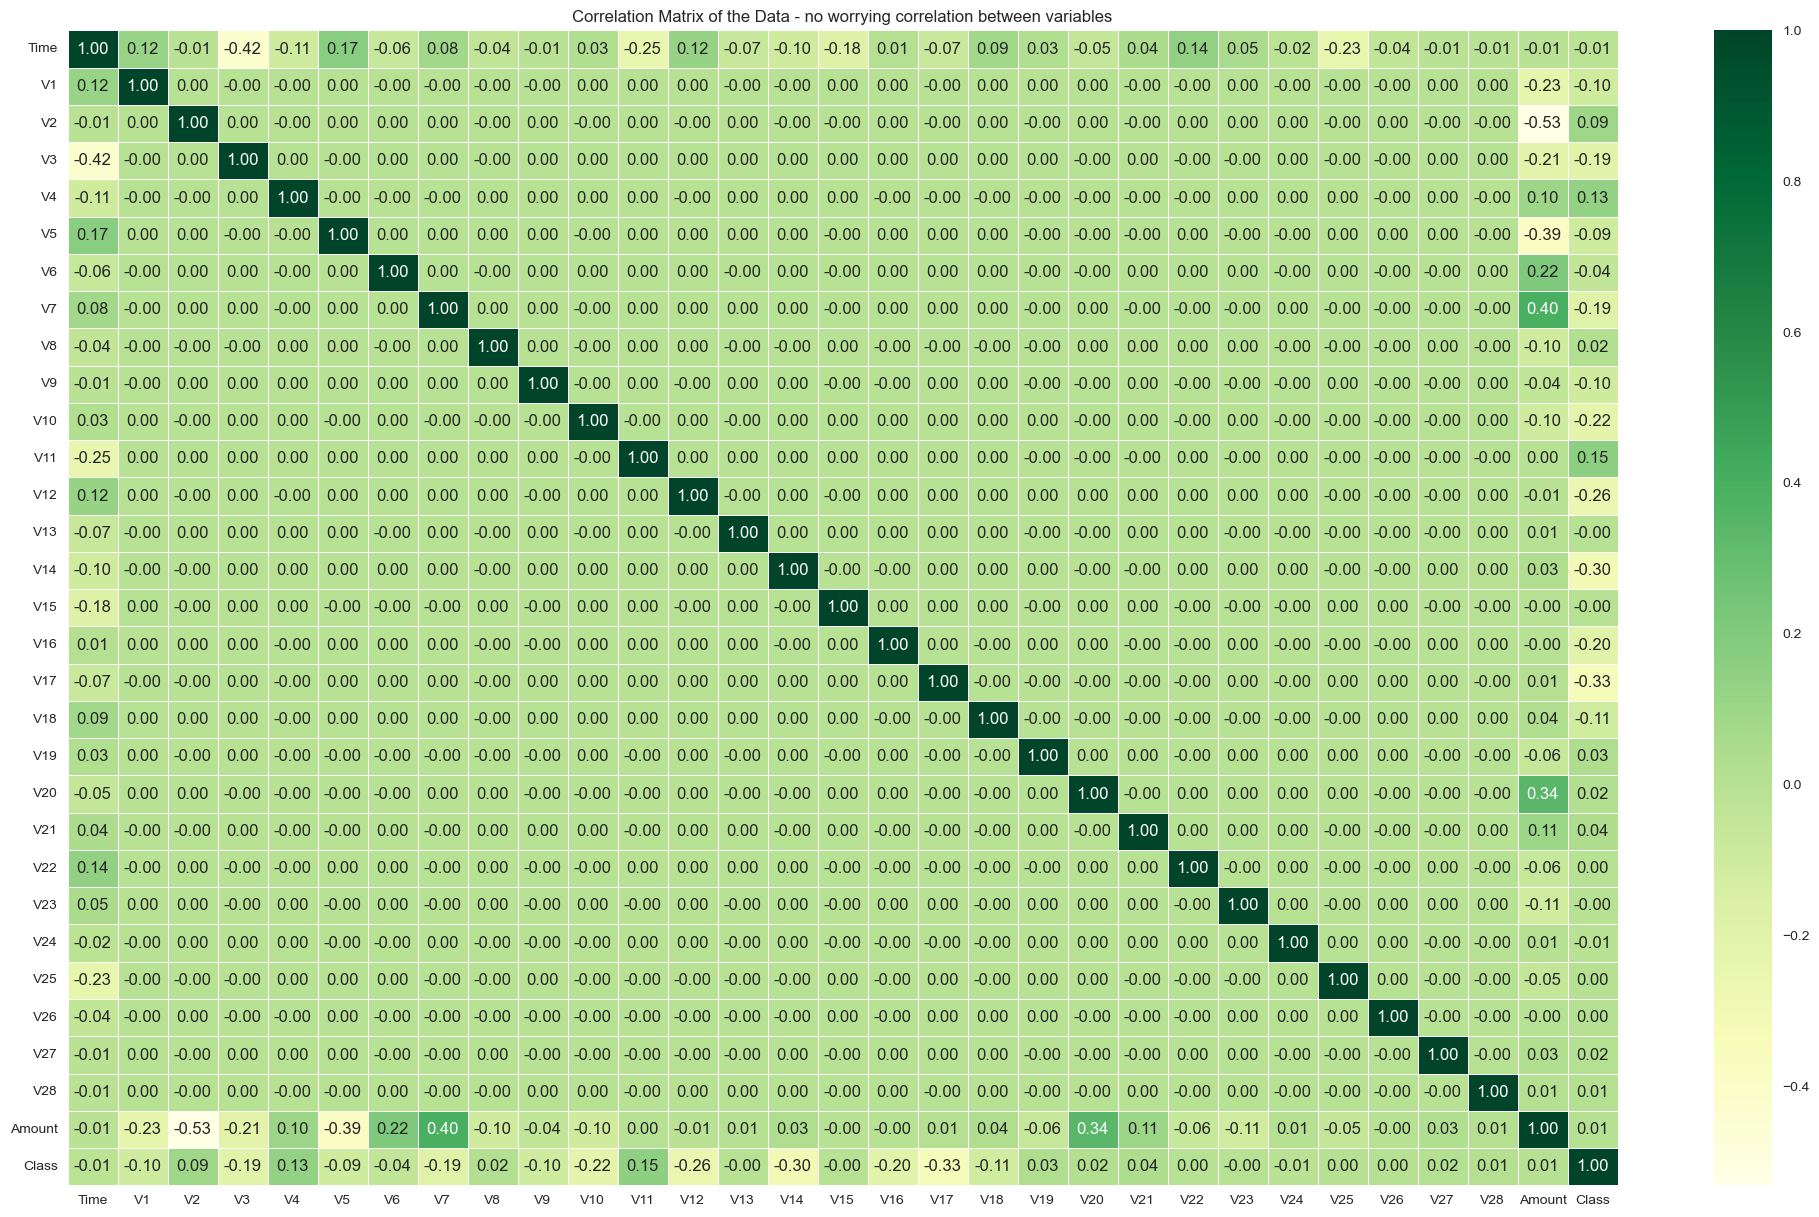

In [20]:
corr= data.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(corr, cmap="YlGn", annot=True, fmt=".2f", linewidths=0.5, cbar=True).set(title="Correlation Matrix of the Data - no worrying correlation between variables")
plt.show()

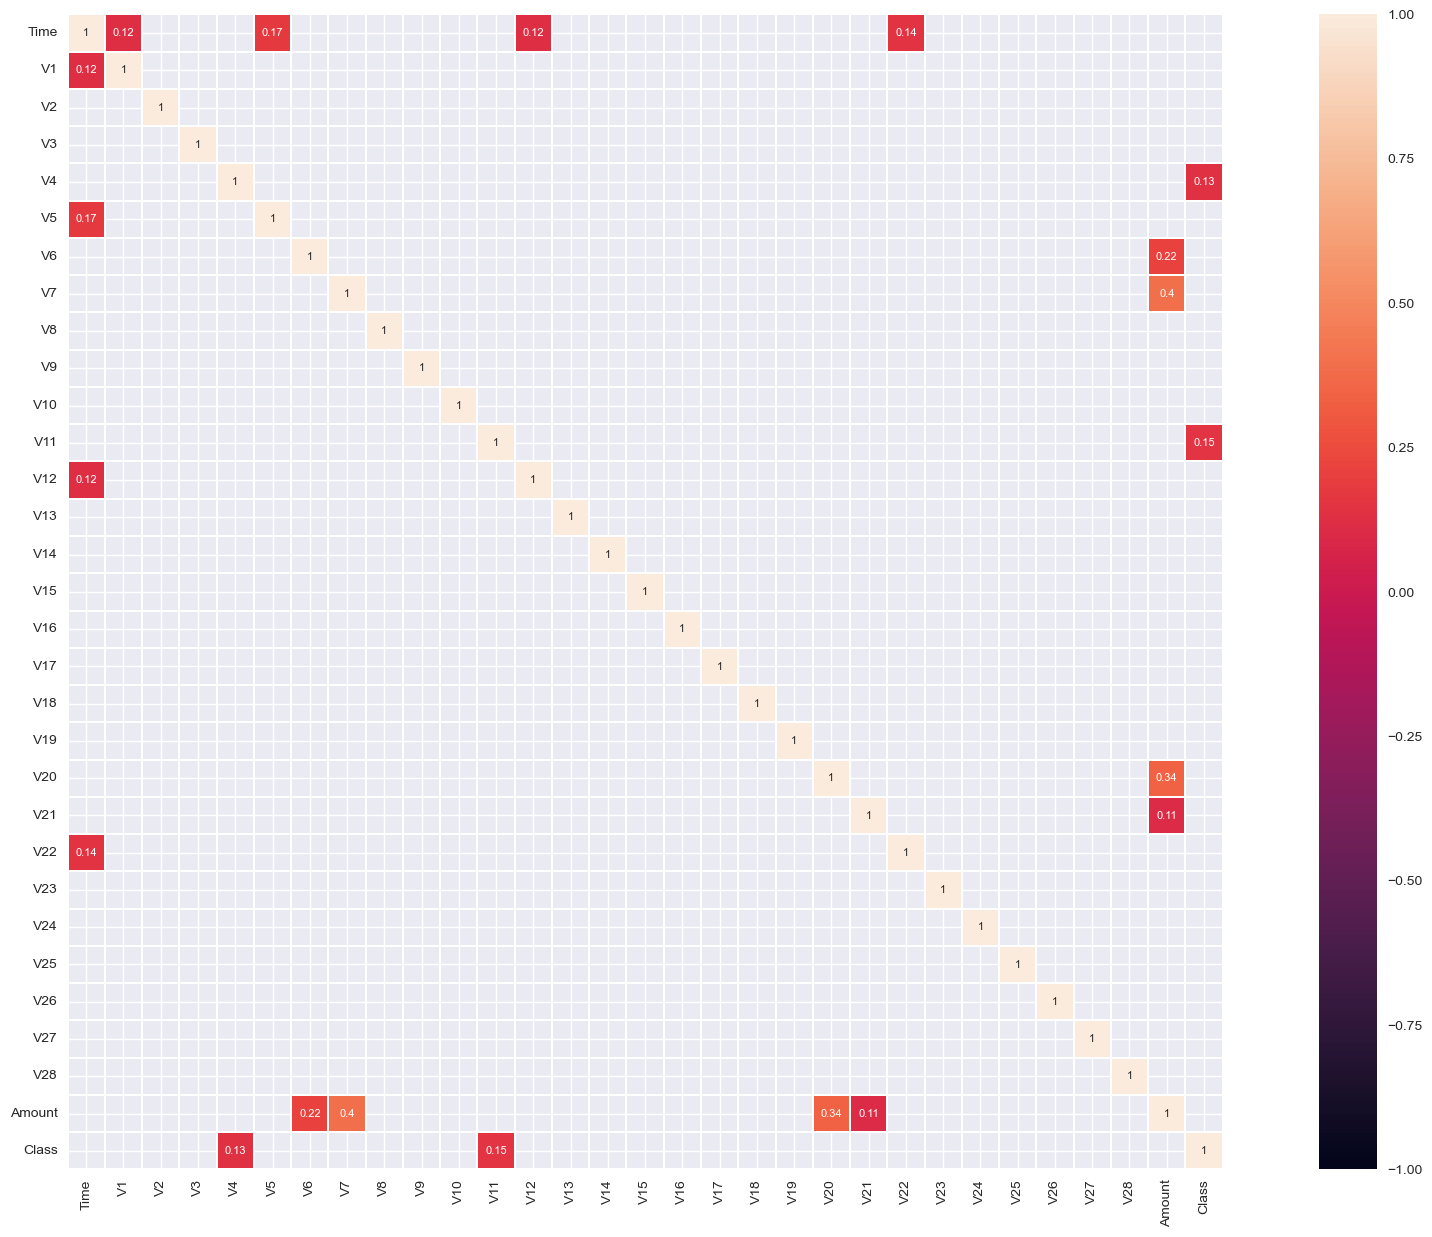

In [21]:
corr = data.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(corr[(corr >= 0.1)], vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True);

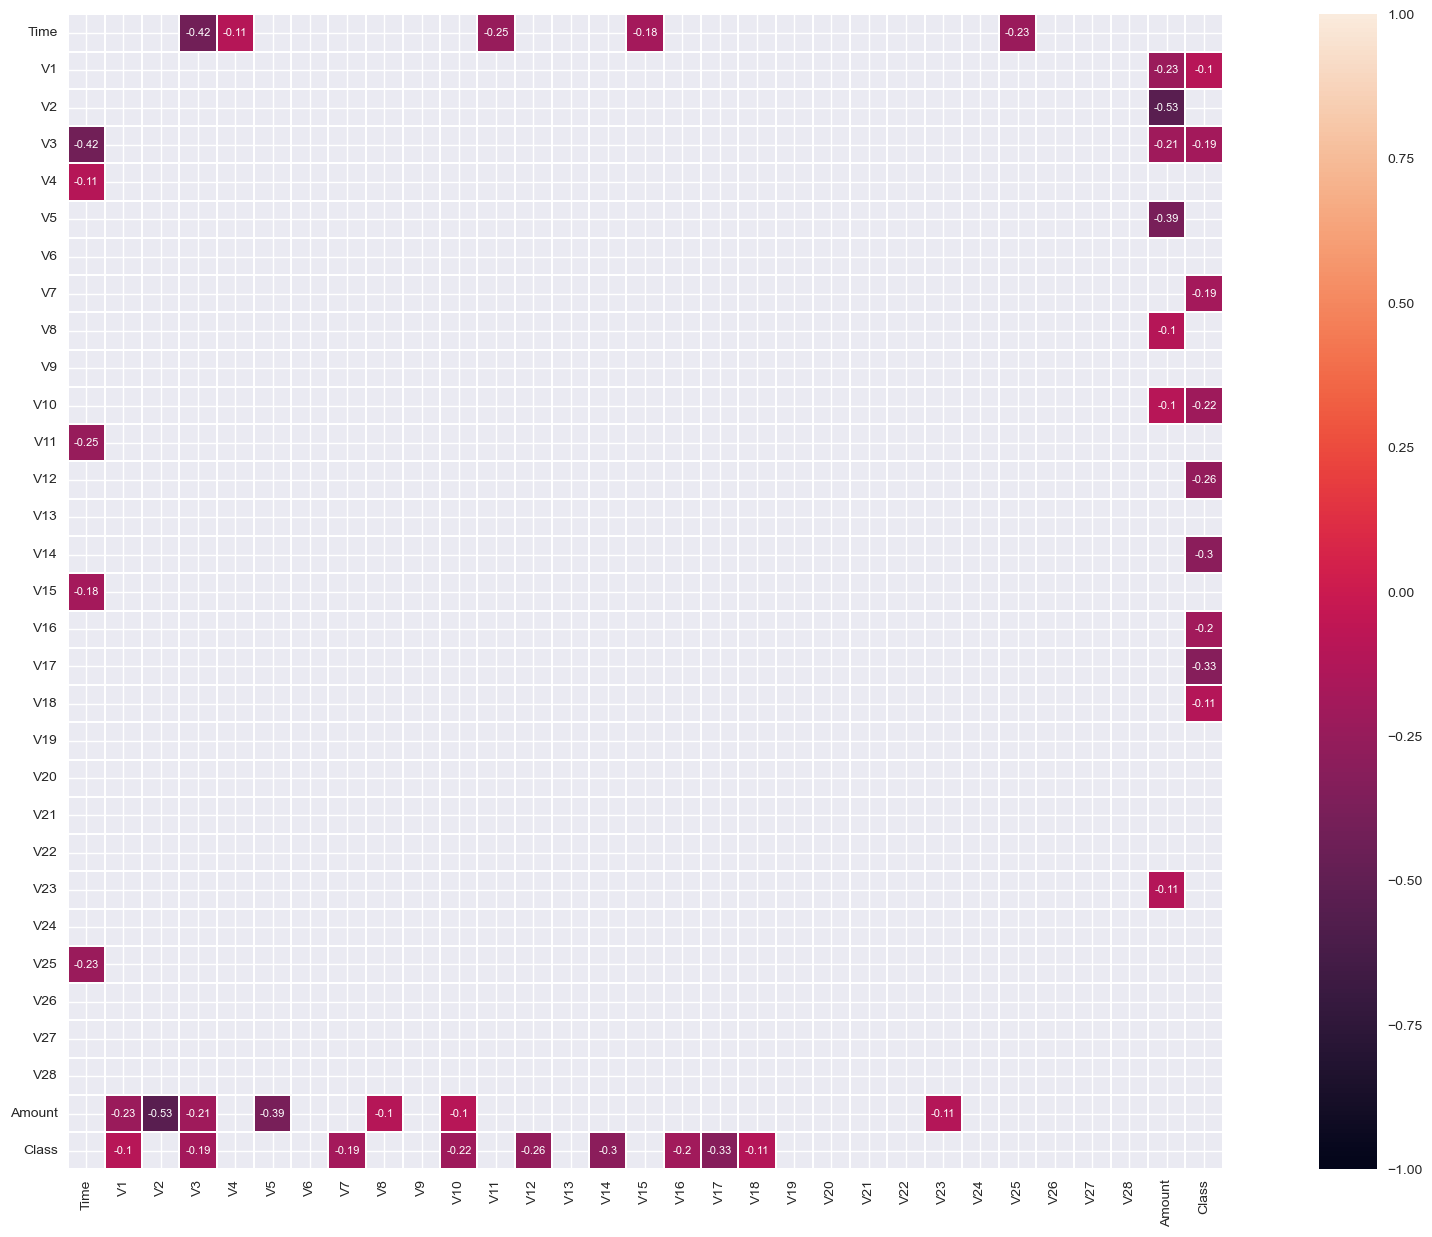

In [22]:
corr = data.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(corr[(corr <= -0.1)], vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True);

###### Correlation with target variable:

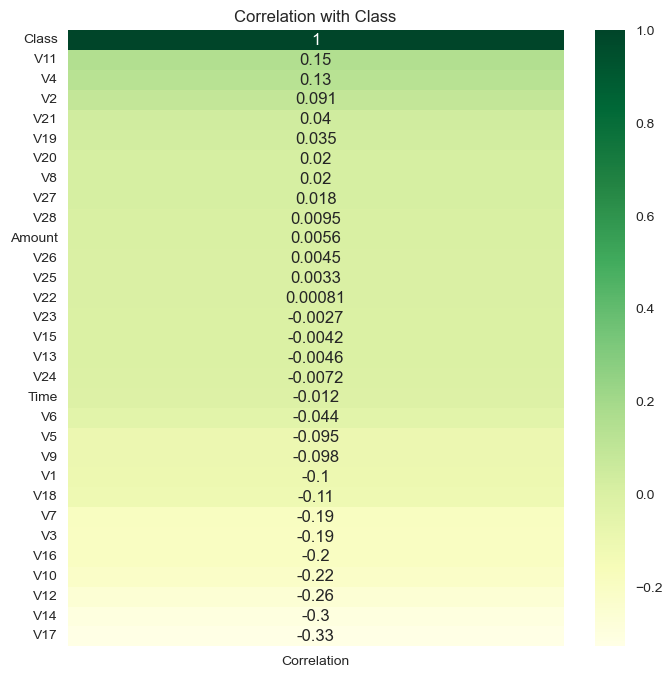

In [23]:
corr_with_target = data.corrwith(data['Class'])

corr_df = pd.DataFrame(corr_with_target, columns=['Correlation'])
corr_df.dropna(inplace=True)

corr_df.sort_values(inplace=True,by="Correlation",ascending=False)
plt.figure(figsize=(8, 8))
sns.heatmap(corr_df, cmap="YlGn", annot=True).set(title="Correlation with Class")
plt.show()

###### let's see if scaling amount and time variables has any effect on the correlation:


[Text(0.5, 1.0, 'Correlation with Class after scaling')]

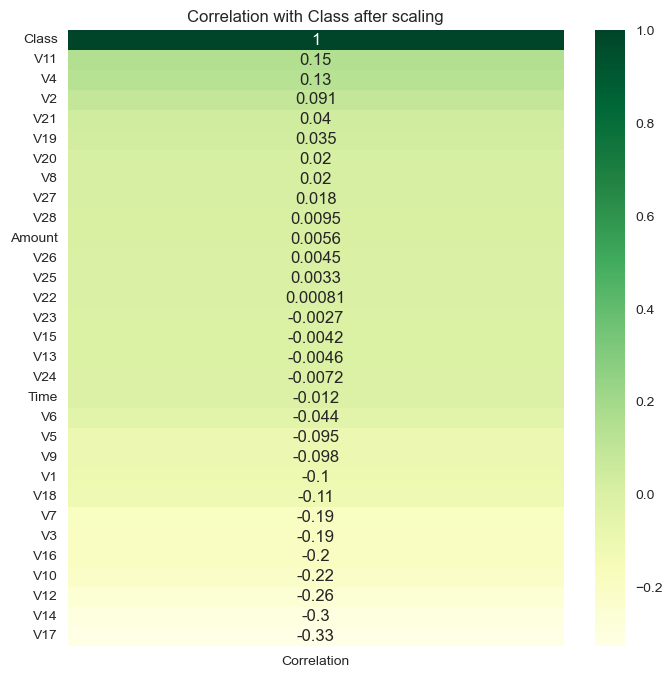

In [28]:
col_to_scale = ["Time","Amount"]
scaler = StandardScaler()

copied_data = data.copy()
copied_data[col_to_scale] = scaler.fit_transform(copied_data[col_to_scale])

corr_with_target = copied_data.corrwith(data['Class'])

corr_df = pd.DataFrame(corr_with_target, columns=['Correlation'])
corr_df.dropna(inplace=True)

corr_df.sort_values(inplace=True,by="Correlation",ascending=False)

plt.figure(figsize=(8, 8))
sns.heatmap(corr_df, cmap="YlGn", annot=True).set(title="Correlation with Class after scaling")

###### Dimensionality Reduction and Visualization of the data variables with respect to the target variable:

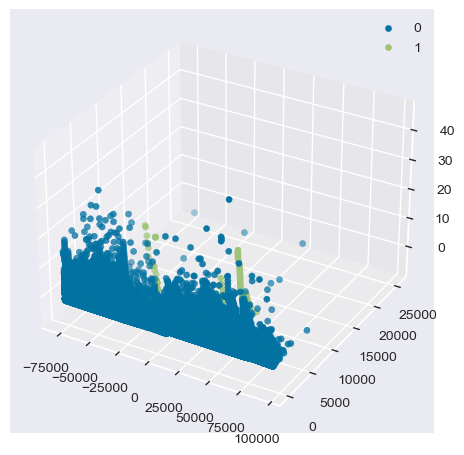

In [25]:
X = data.drop(columns='Class')
pca = PCA(n_components=3)
components = pca.fit_transform(X)

components = pd.DataFrame(components, columns=['PC1', 'PC2', 'PC3'])
components["Class"] = data["Class"]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in components.Class.unique():
    ax.scatter(components.PC1[components.Class==s],
               components.PC2[components.Class==s],
               components.PC3[components.Class==s],
               label=s)

ax.legend()

###### Understand the data from numerical columns distributions and target variable distribution:

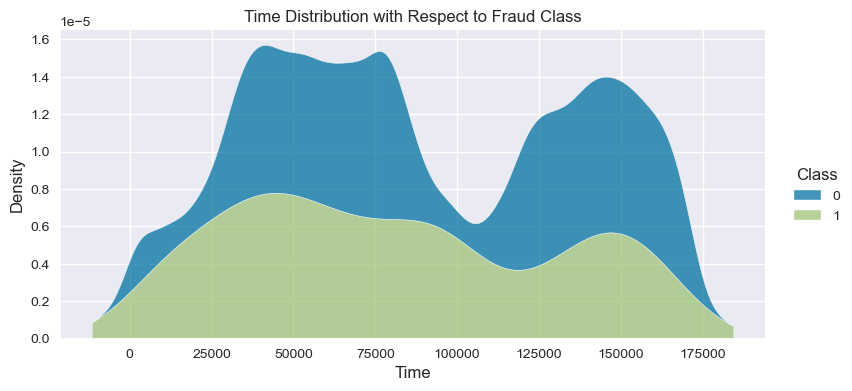

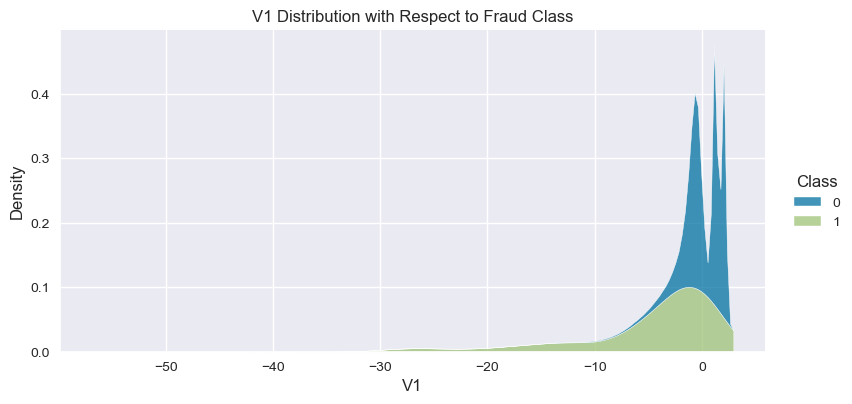

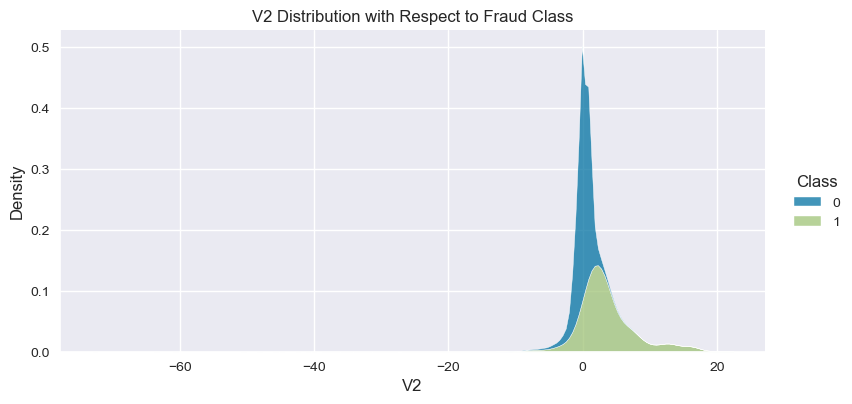

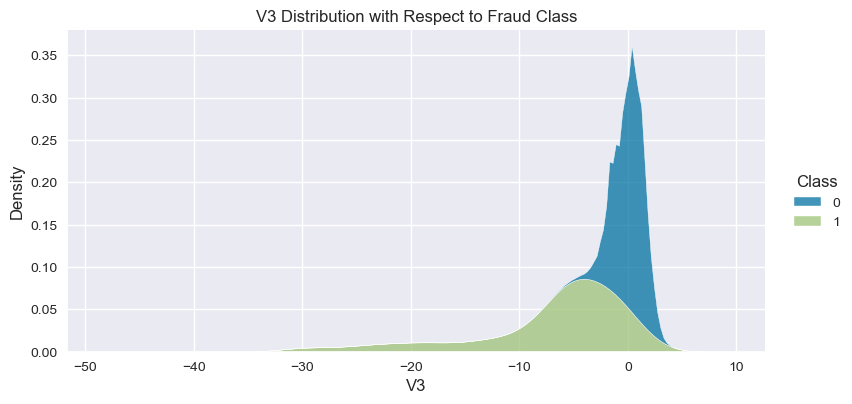

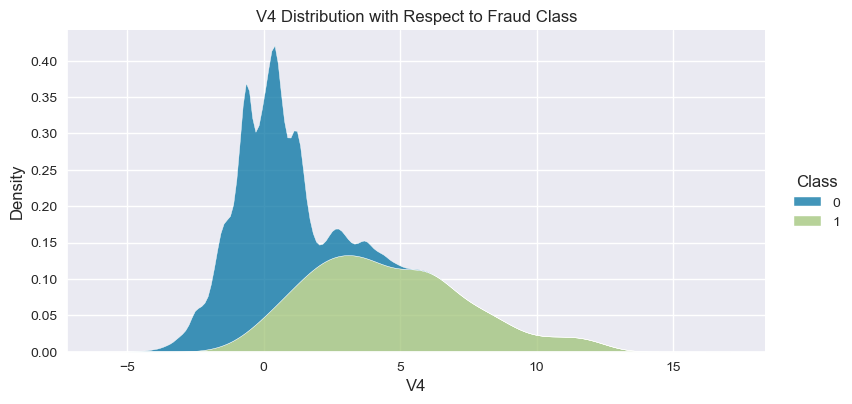

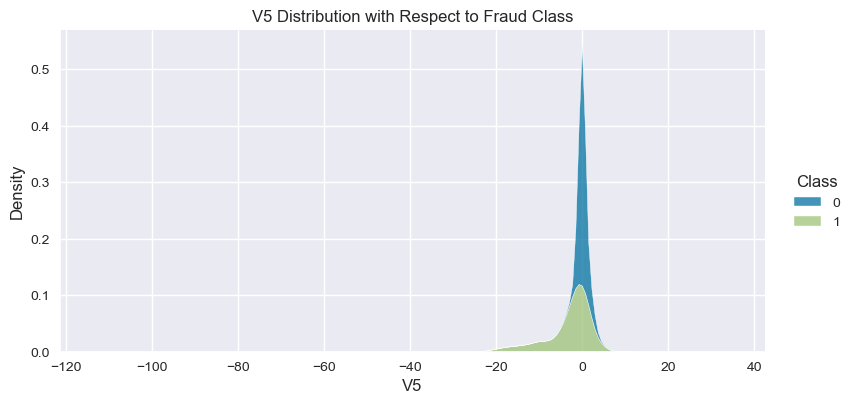

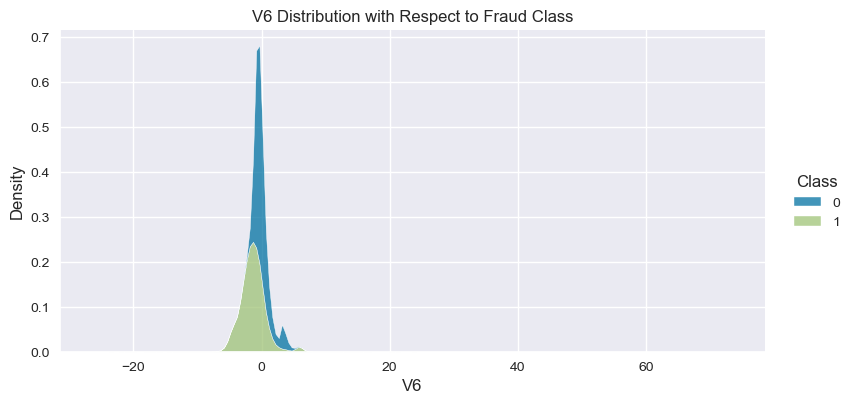

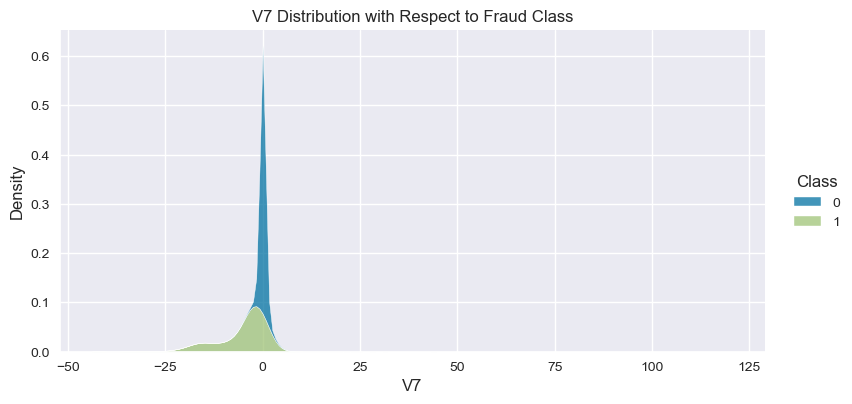

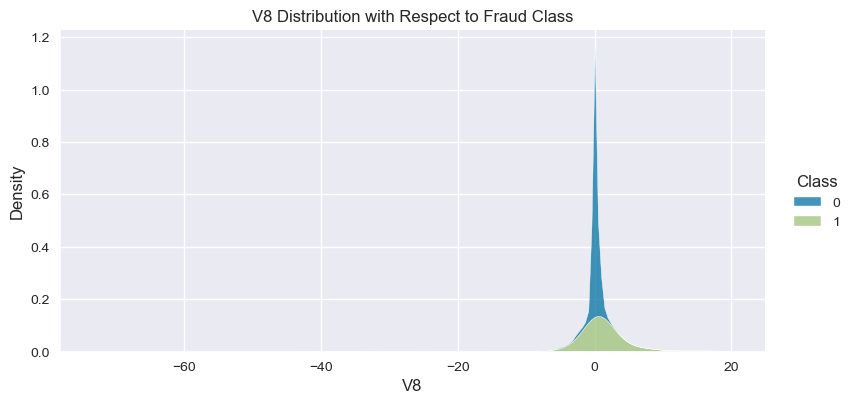

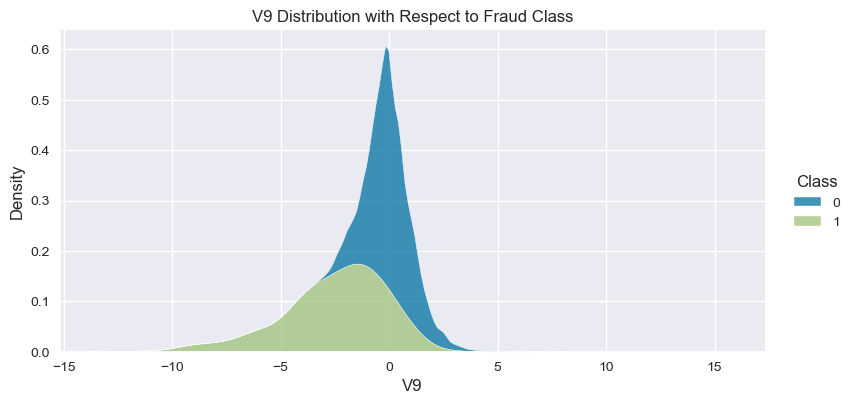

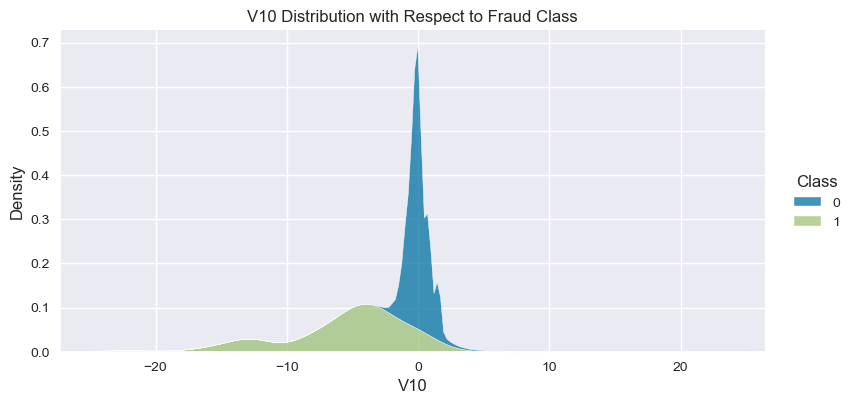

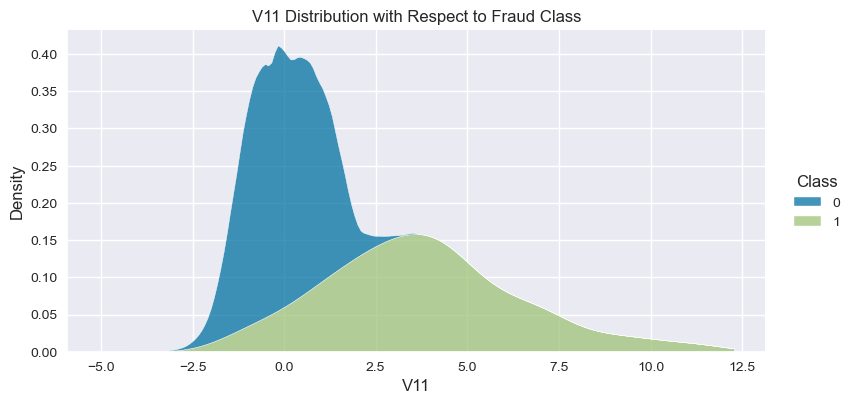

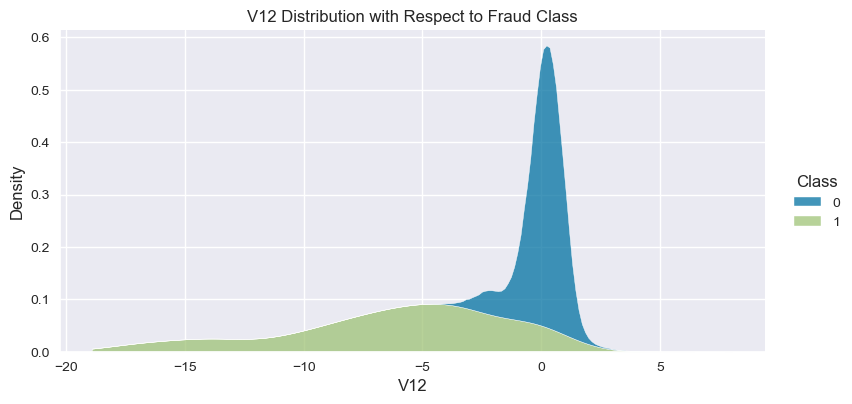

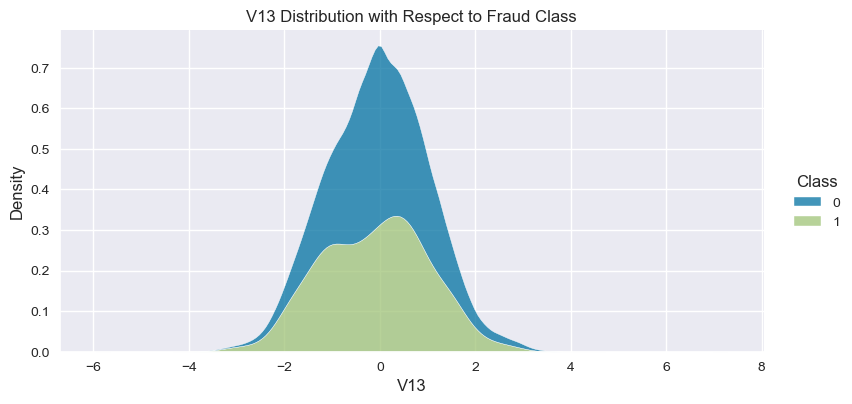

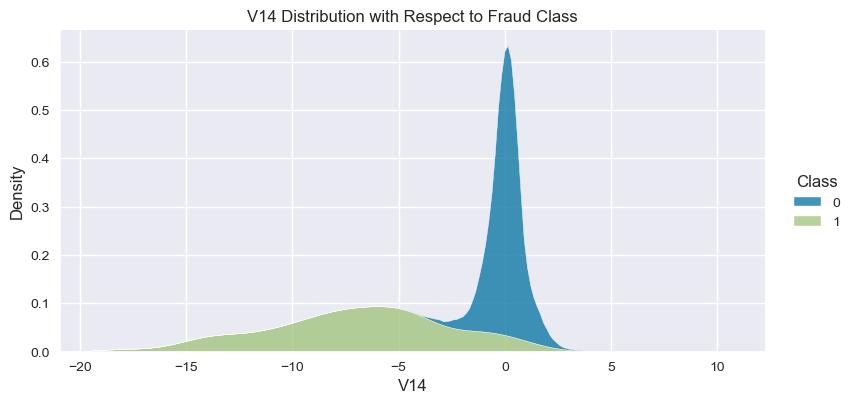

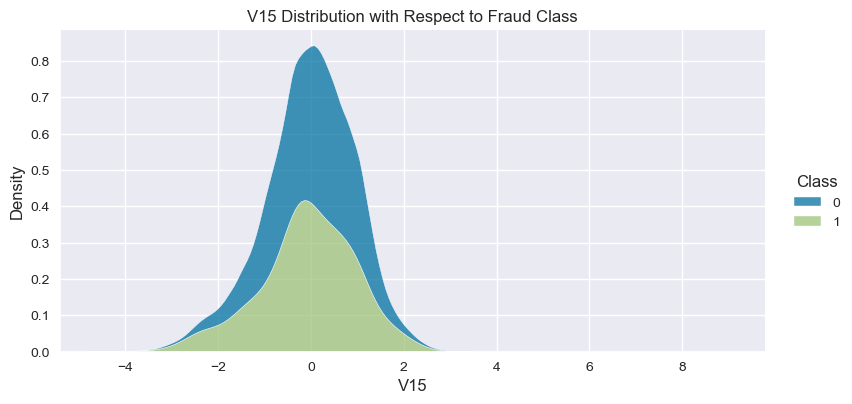

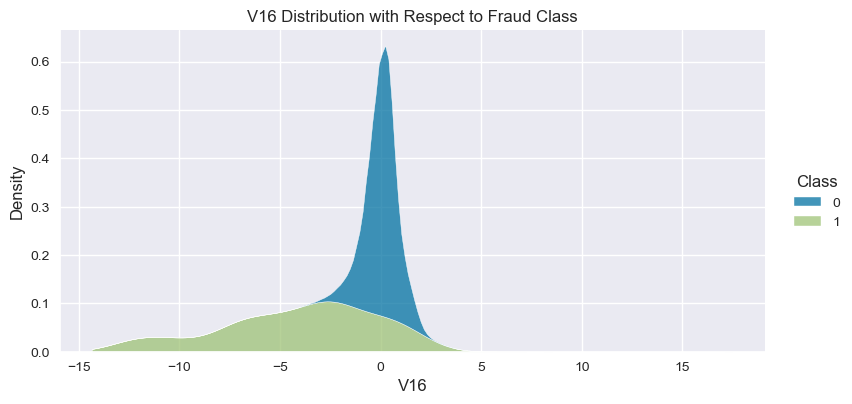

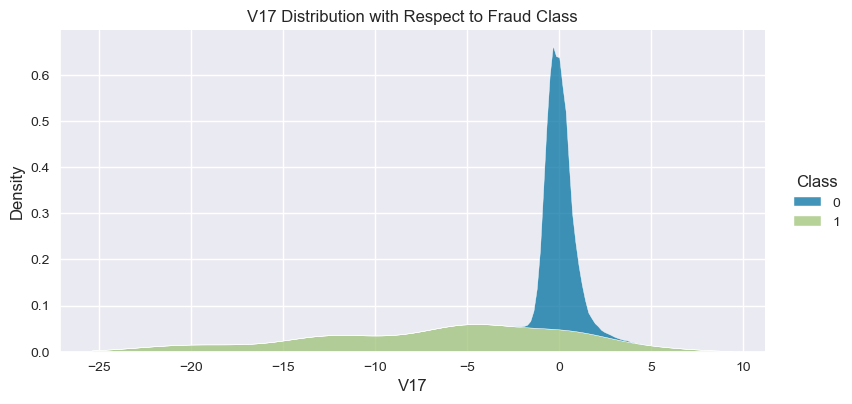

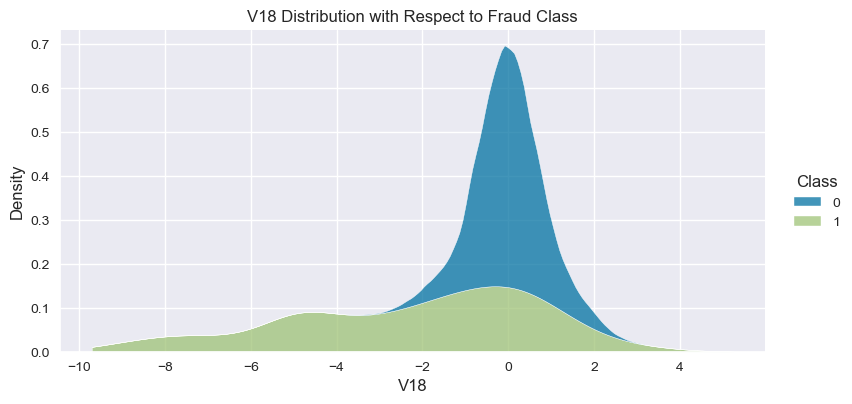

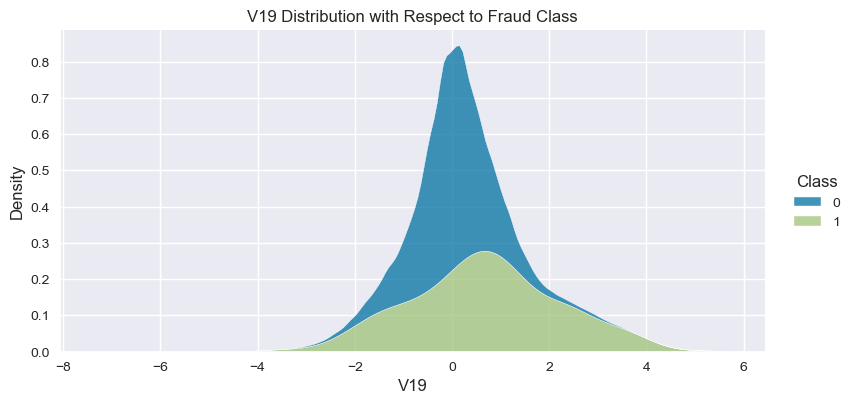

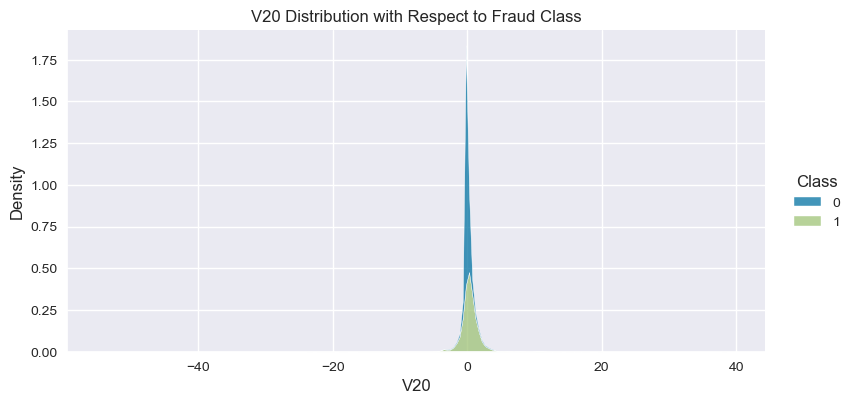

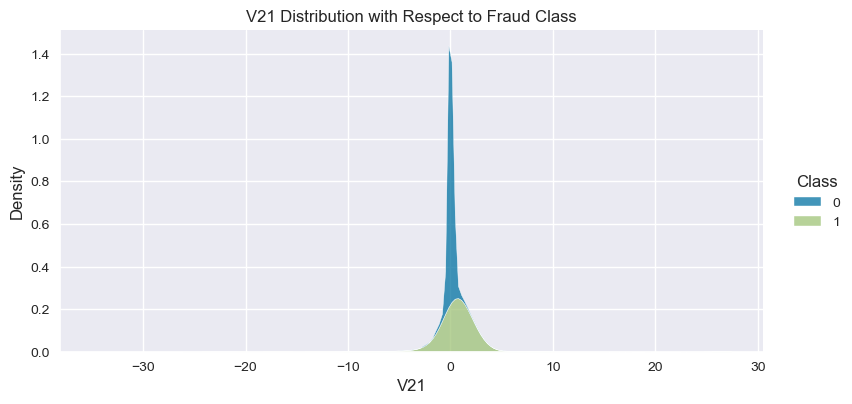

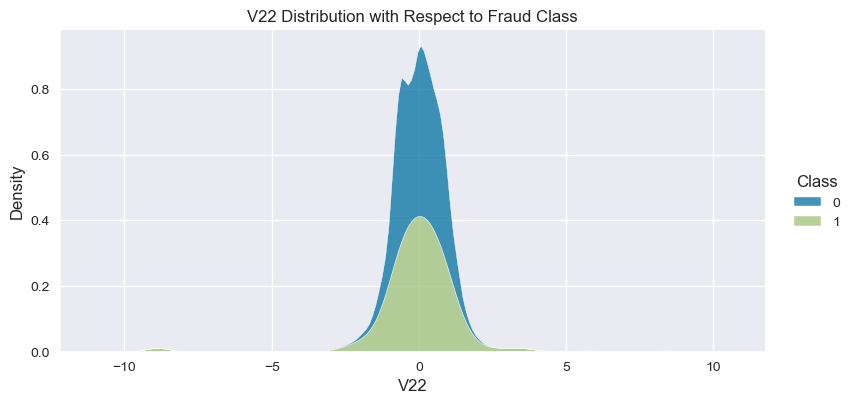

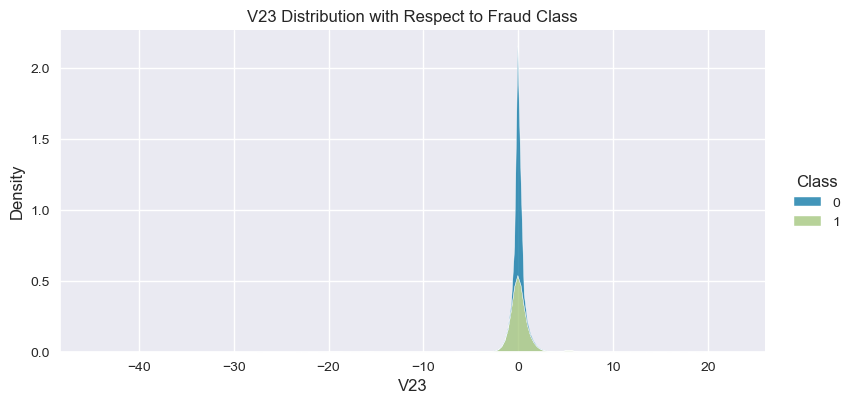

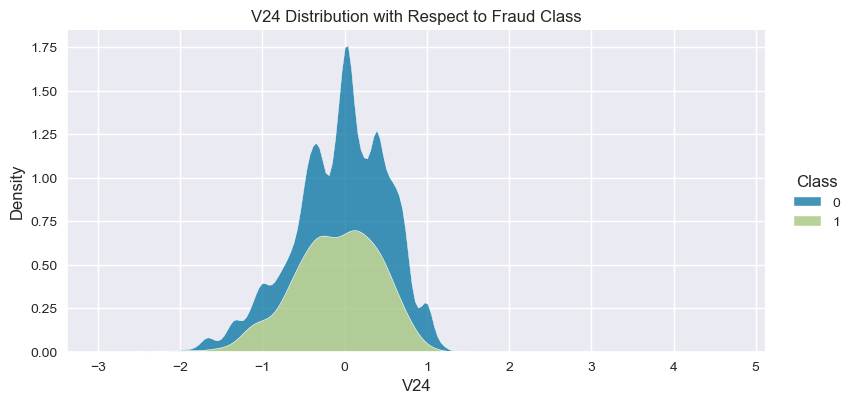

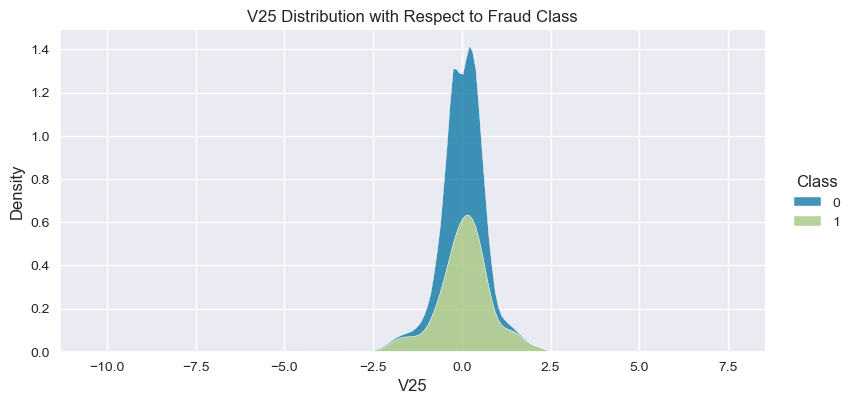

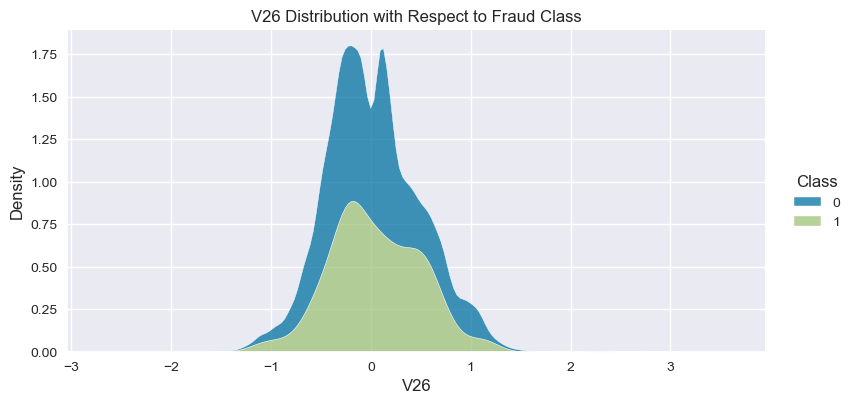

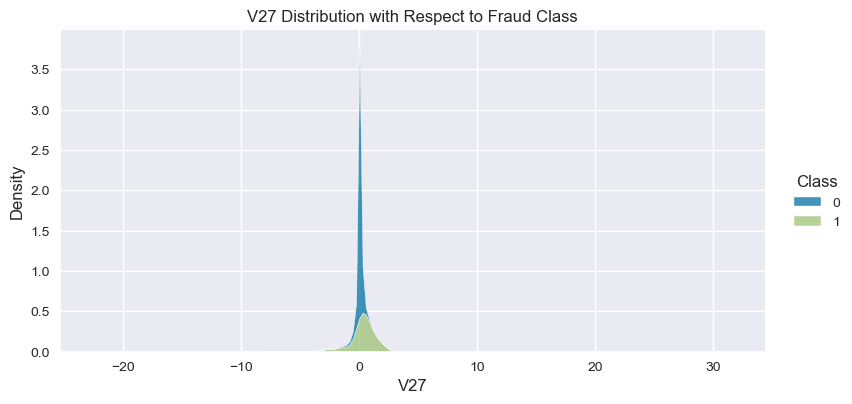

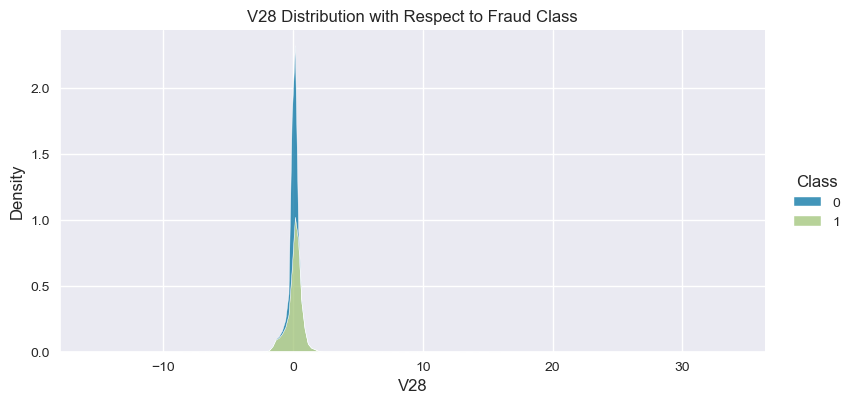

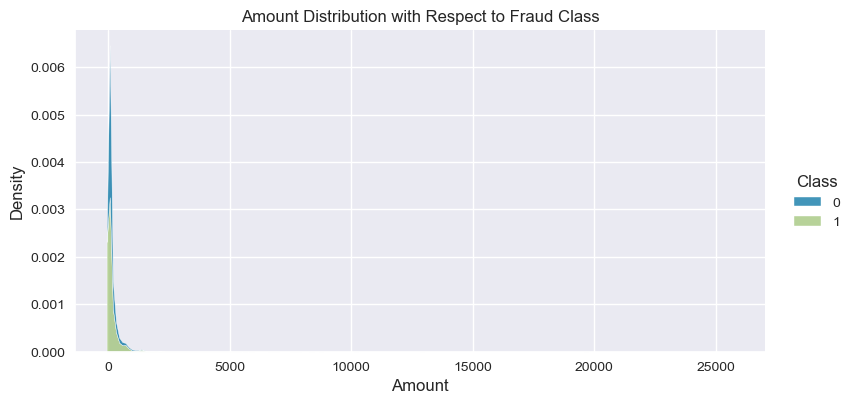

In [29]:
numeric_data_col = data._get_numeric_data().columns
for col in numeric_data_col:
    if col != "Class":
       sns.displot(data,
            x=col,
            hue="Class",
            # stat="density",
            common_norm=False,
            multiple="stack",
            height=4,
            aspect=2,
            kind="kde",
            ).set(title=col+" Distribution with Respect to Fraud Class")

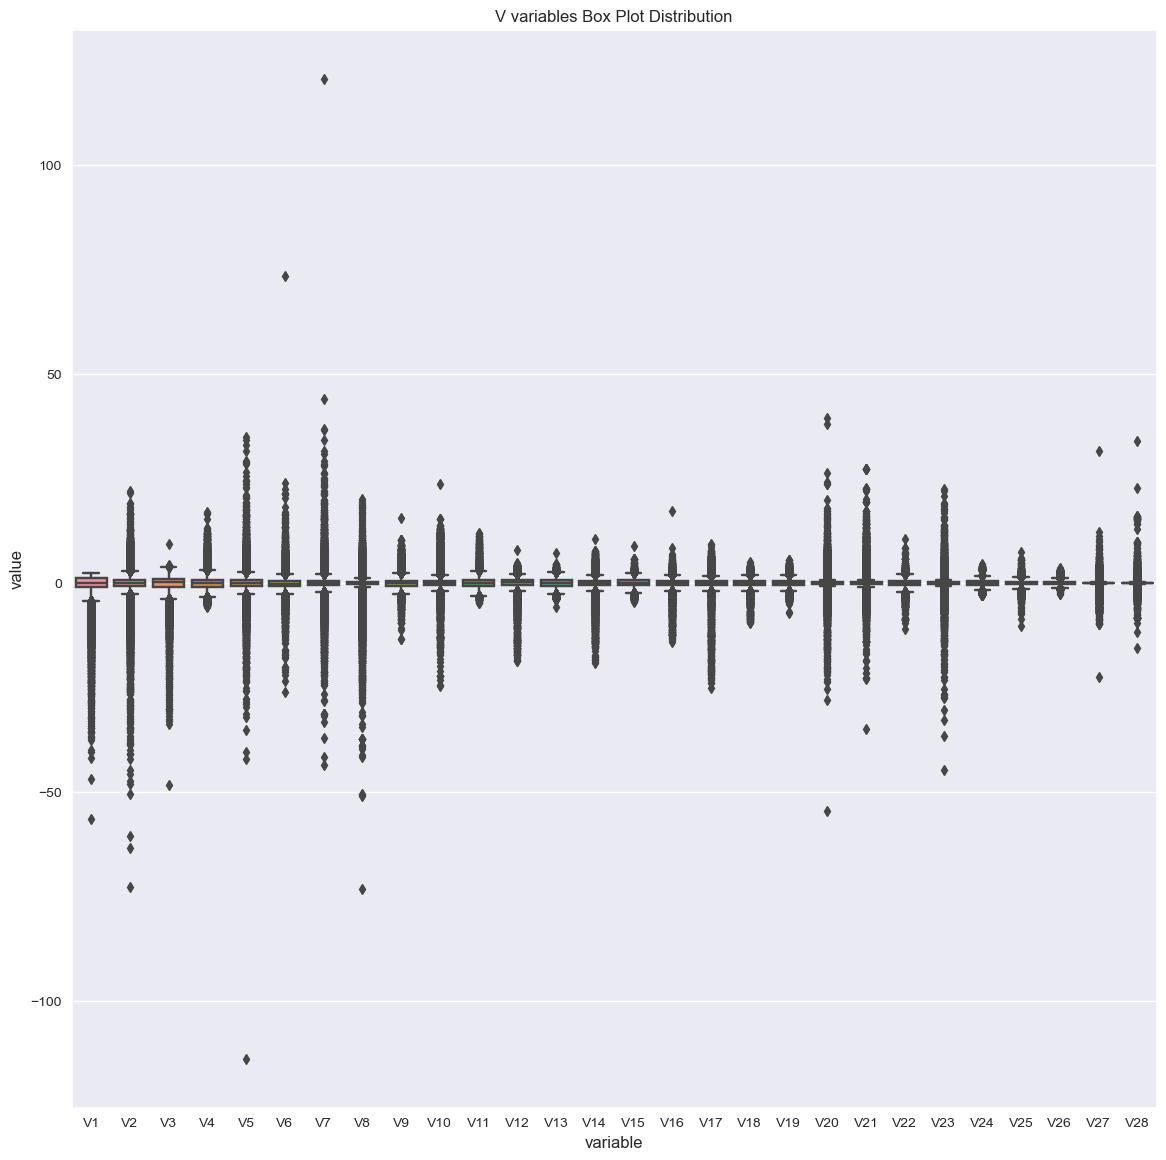

In [31]:
plt.figure(figsize=(14, 14))
vs = [col for col in data.columns if col.startswith("V")]
sns.boxplot(x="variable", y="value", data=pd.melt(data[vs])).set(title="V variables Box Plot Distribution")
plt.show()

In [33]:
# generate id column to keep track of the rows:
data["ID"] = range(1, len(data) + 1)
# check if ID is unique:
data["ID"].is_unique

True

###### Hard to detect outliers by inspecting the data, let's use IQR to detect outliers:

In [34]:

# we aim to calculate the IQR for each column in the DataFrame for the majority class:

# Define the threshold for outliers
threshold = 1.5
non_fraud = data[data["Class"] ==0]
independent_variables = data.drop(["Class","ID"],axis=1).columns

overall_outliers = []
# # Iterate over each column in the DataFrame
for col in independent_variables:

    # Calculate the IQR for the current column
    Q1 = non_fraud[col].quantile(0.25)
    Q3 = non_fraud[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Find the outliers in the current column
    outliers = non_fraud[(non_fraud[col] < lower_bound) | (non_fraud[col] > upper_bound)]["ID"]

    # Append the outliers to the overall list
    overall_outliers.extend(outliers.tolist())


#non fraud outliers:
len(set(overall_outliers))


138361

In [35]:
# copy the data to keep track of the original data:
outliers_removed = data.copy()

# drop the outliers:
outliers_removed = outliers_removed[~outliers_removed["ID"].isin(set(overall_outliers))]

###### Check the class distribution after dropping outliers:

<AxesSubplot: title={'center': 'Class Distribution after dropping outliers still heavily imbalanced'}>

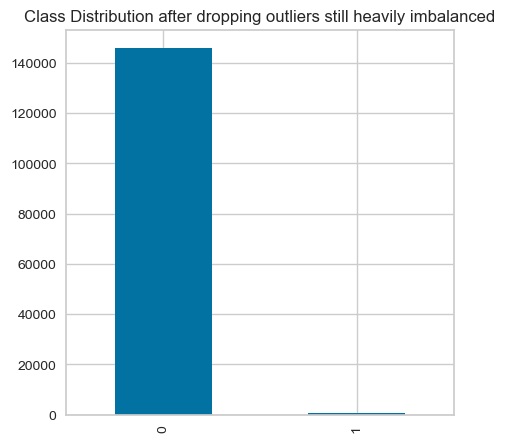

In [20]:
plt.figure(figsize=(5, 5))
outliers_removed["Class"].value_counts().plot(kind="bar",title="Class Distribution after dropping outliers still heavily imbalanced")

###### Show correlation after dropping outliers:

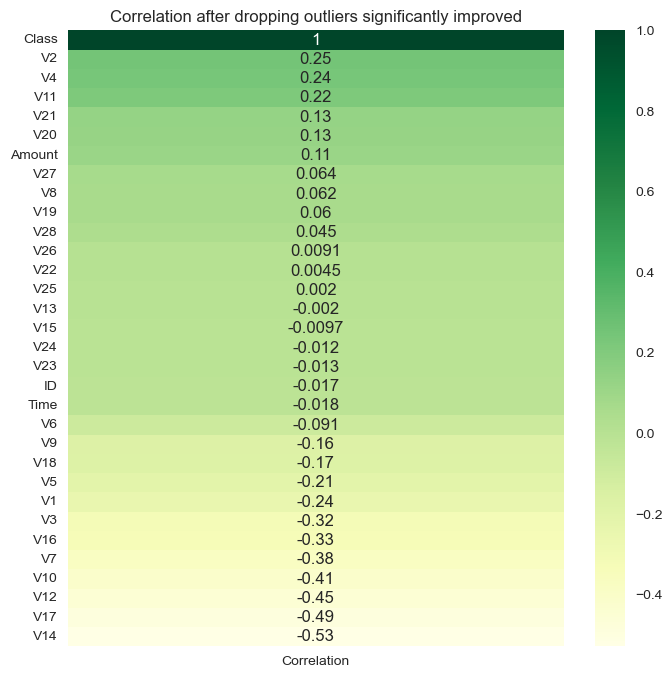

In [36]:
corr_with_target = data.corrwith(outliers_removed['Class'])

corr_df = pd.DataFrame(corr_with_target, columns=['Correlation'])
corr_df.dropna(inplace=True)
corr_df.sort_values(inplace=True,by="Correlation",ascending=False)
plt.figure(figsize=(8, 8))
sns.heatmap(corr_df, cmap="YlGn", annot=True).set(title="Correlation after dropping outliers significantly improved")
plt.show()

###### visualize the correlation again:

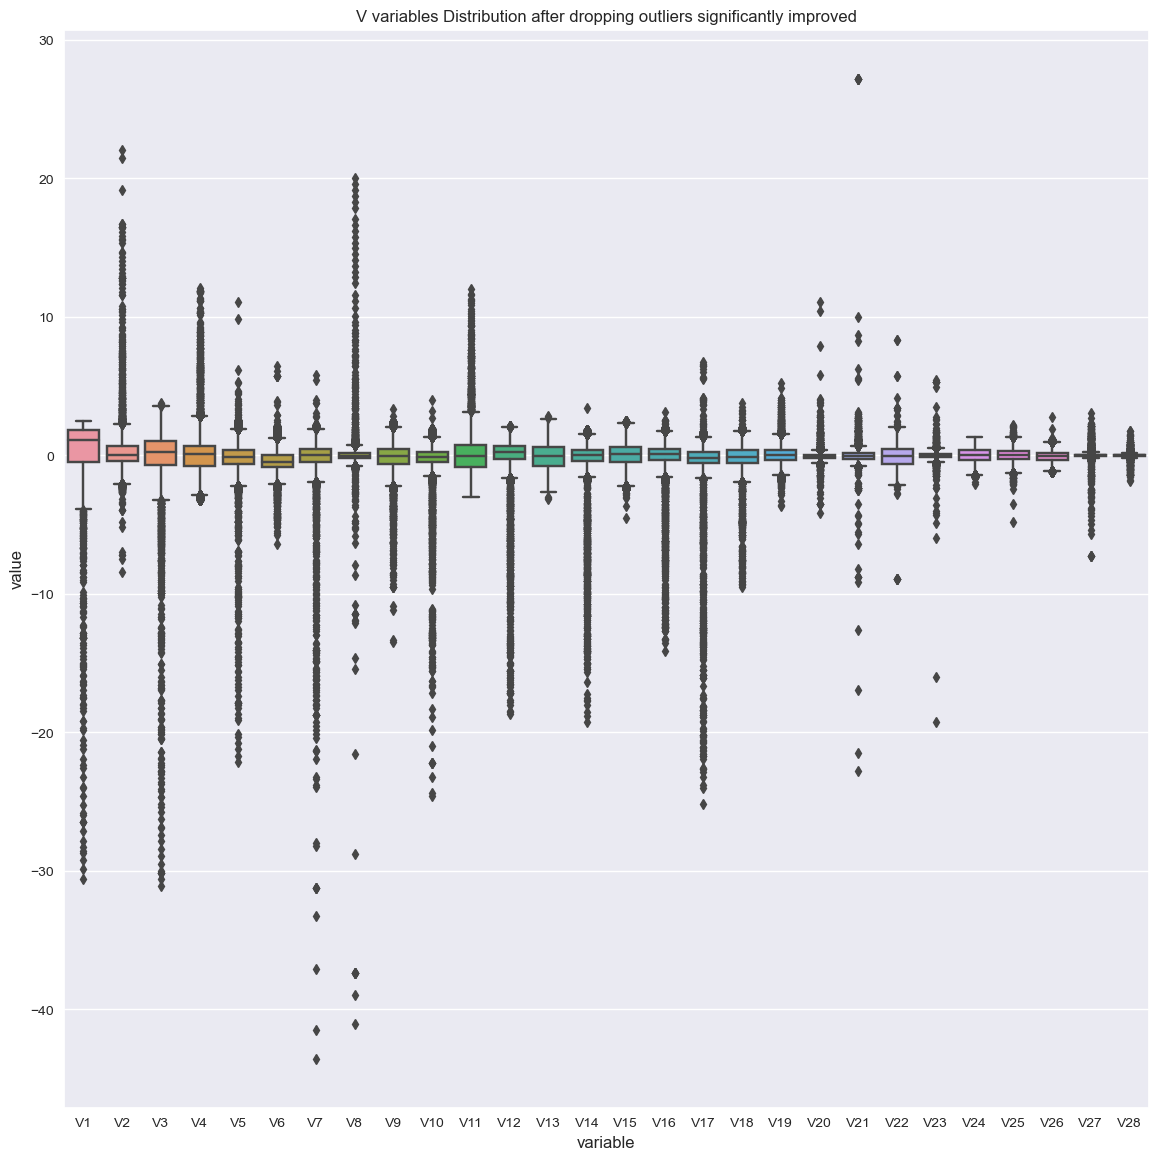

In [37]:
plt.figure(figsize=(14, 14))
vs = [col for col in data.columns if col.startswith("V")]
sns.boxplot(x="variable", y="value", data=pd.melt(outliers_removed[vs])).set(title="V variables Distribution after dropping outliers significantly improved")
plt.show()

### Observations:
- Amount variable correlates highly compared to other variables with V20,V7,V6,V5,V4,V3,V2,V2.
- Time variable correlates negatively with V25,V15,V11,V3.
- Other variables don't correlate with each other or the Vs variables since they are reduced with PCA and represent interaction with features.
- Independent variables, V11, V4, V2, V21m V19, V20, V8 correlated positively with the independent variable
- The correlation between the target variable and the independent variables improved after dropping outliers, but still we might risk removing information from the data, its hard to decide to keep or remove outliers since many outliers can be informative outliers, and we can't take such decision without domain knowledge.
- The density distribution of the data for the numerical variables shows non-linear separation boundary by separation.
- Projecting data on 3D space with PCA shows that the data is not linearly separable and there is a pattern shared among or clusters in the data. for fraud class.
- The data is still heavily imbalanced.
- There are no missing values in the data.


## Modeling:
### Statistical Analysis:

In [38]:
data.drop("ID",axis=1,inplace=True,errors="ignore")
# Split the data into train and test sets with fixed random state:
X = data.drop(['Class'], axis=1)
y = data['Class']

# split data into training and testing:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
# Fit a logistic regression model using Statsmodels
X = sm.add_constant(X)  # Add a constant term to the feature matrix
result = sm.Logit(y, X).fit()

# Print the model summary:
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.003914
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               284807
Model:                          Logit   Df Residuals:                   284776
Method:                           MLE   Df Model:                           30
Date:                Wed, 28 Jun 2023   Pseudo R-squ.:                  0.6922
Time:                        16:12:06   Log-Likelihood:                -1114.8
converged:                       True   LL-Null:                       -3621.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.3917      0.249    -33.652      0.000      -8.880      -7.903
Time       -3.742e-06   2.26

In [40]:
statistical_results_as_frame = get_dataframe_from_summary(result)
statistical_results_as_frame[statistical_results_as_frame["P>|z|"] <= 0.000].style.background_gradient(cmap='summer')

### Simple Logistic Regression "Establishing a Baseline":

In [41]:
logistic_regression_model = LogisticRegression(random_state=12234526, penalty="l2", solver="newton-cholesky")
logistic_regression_model.fit(x_train, y_train)

# Predict on test data:
y_predict = logistic_regression_model.predict(x_test)

# classification report:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.88      0.63      0.74       136

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



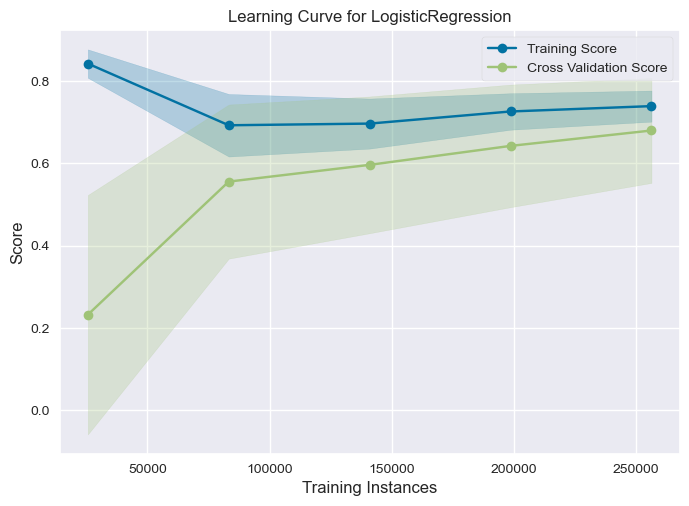

In [43]:
ge_learning_curve(logistic_regression_model, X, y, cv=10, scoring='f1')

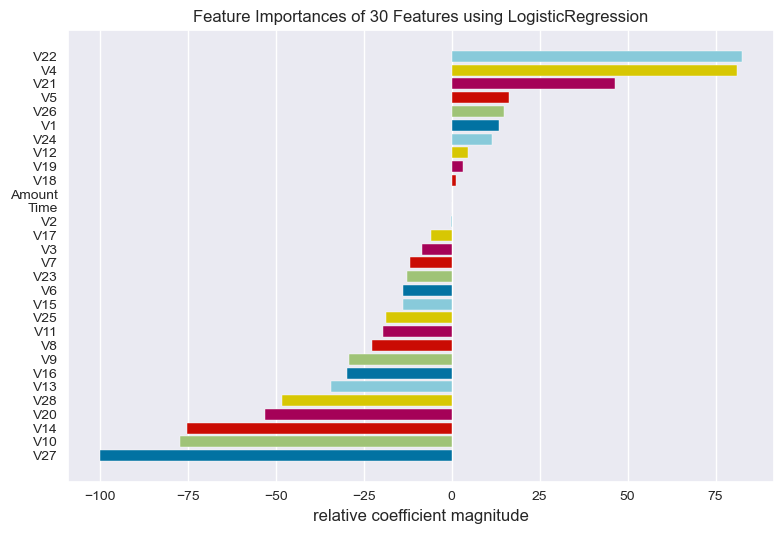

In [44]:
get_FeatureImportances(logistic_regression_model, x_train, y_train)

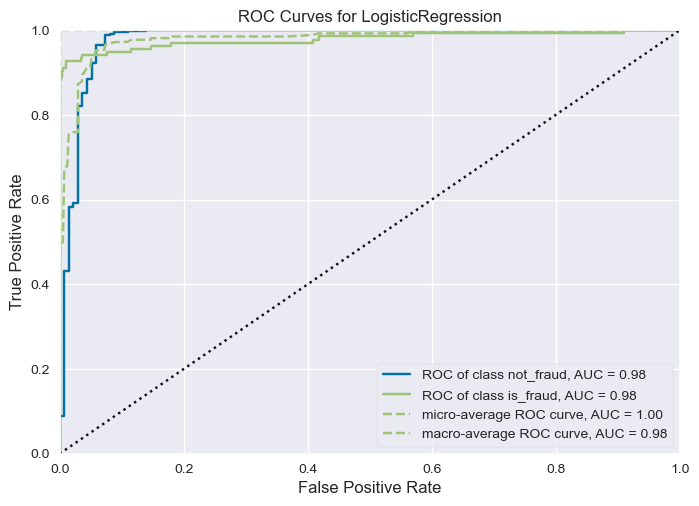

In [45]:
get_ROCAUC(logistic_regression_model, x_train, y_train, x_test, y_test, classes=["not_fraud", "is_fraud"])

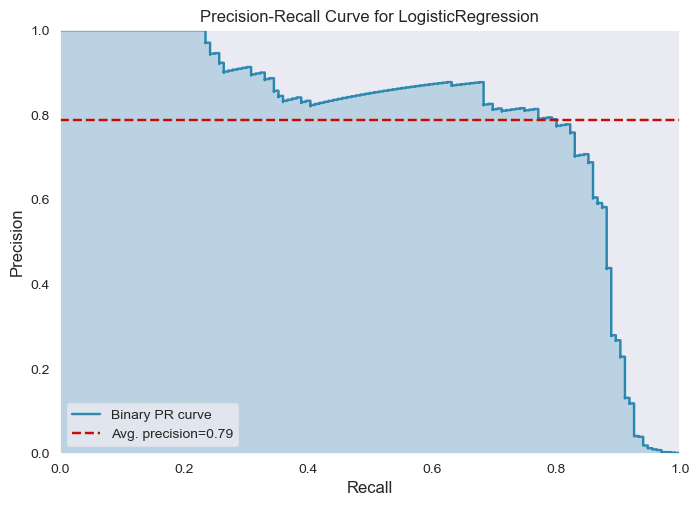

In [46]:
get_PrecisionRecallCurve(logistic_regression_model, x_train, y_train, x_test, y_test)

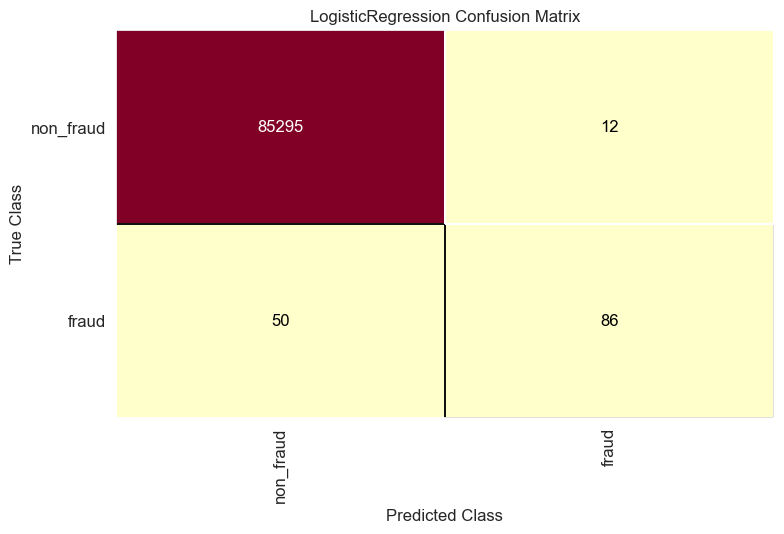

In [47]:
get_ConfusionMatrix(logistic_regression_model, x_train, y_train, x_test, y_test)

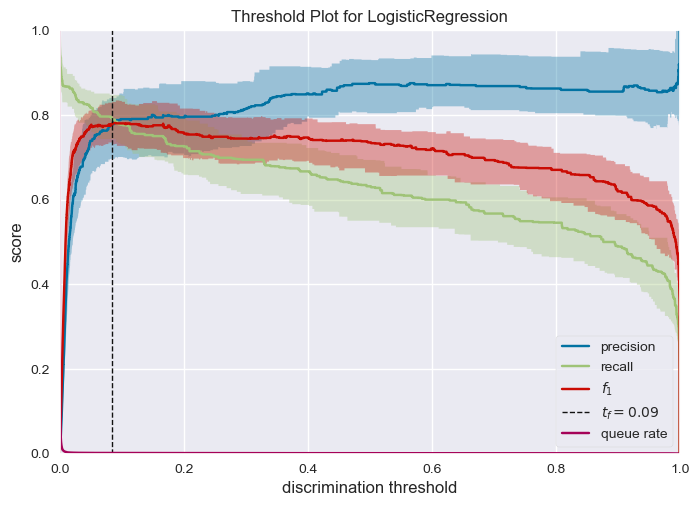

In [48]:
get_DiscriminationThreshold(logistic_regression_model, X, y)

### Feature Selection:
###### Let's try to improve the model by eliminating features and employing feature selection techniques:

In [49]:
rfe = RFE(logistic_regression_model)
fit = rfe.fit(X, y)
selected_features = X.columns[fit.support_].tolist()
selected_features

['V4',
 'V6',
 'V8',
 'V9',
 'V10',
 'V13',
 'V14',
 'V16',
 'V20',
 'V21',
 'V22',
 'V23',
 'V25',
 'V27',
 'V28']

In [50]:
reduced_features_train = x_train[selected_features]
reduced_features_test = x_test[selected_features]

logistic_regression_model.fit(reduced_features_train, y_train)

# Predict on test data:
y_predict_reduced = logistic_regression_model.predict(reduced_features_test)

print(classification_report(y_test, y_predict_reduced))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.64      0.73       136

    accuracy                           1.00     85443
   macro avg       0.93      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



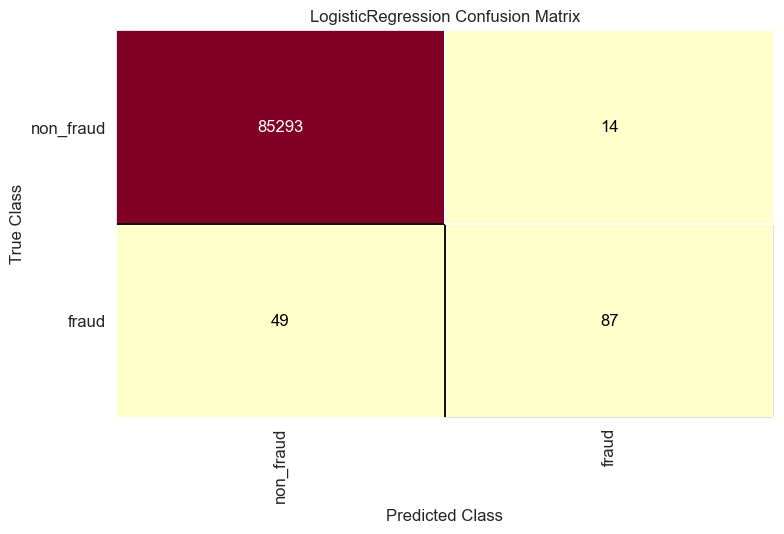

In [52]:
get_ConfusionMatrix(logistic_regression_model, reduced_features_train, y_train, reduced_features_test, y_test)

### Under-Sampling the Majority Class "Non-Fraud":
###### where we employ under sampling to balance the data and remove redundant data points in a highly imbalanced dataset:

In [54]:
# calculate the percentage of fraud cases:
value_counts = pd.Series(y).value_counts()
percentages = value_counts / len(y) * 100
print(percentages)

0    99.827251
1     0.172749
Name: Class, dtype: float64


In [55]:
# randomly under-sample the majority class with a given ratio:
rus = RandomUnderSampler(random_state=0, sampling_strategy = 0.4 / 100)
X_resampled, y_resampled = rus.fit_resample(X, y)
y_resampled.value_counts()

0    123000
1       492
Name: Class, dtype: int64

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36915
           1       0.91      0.77      0.83       133

    accuracy                           1.00     37048
   macro avg       0.95      0.88      0.92     37048
weighted avg       1.00      1.00      1.00     37048



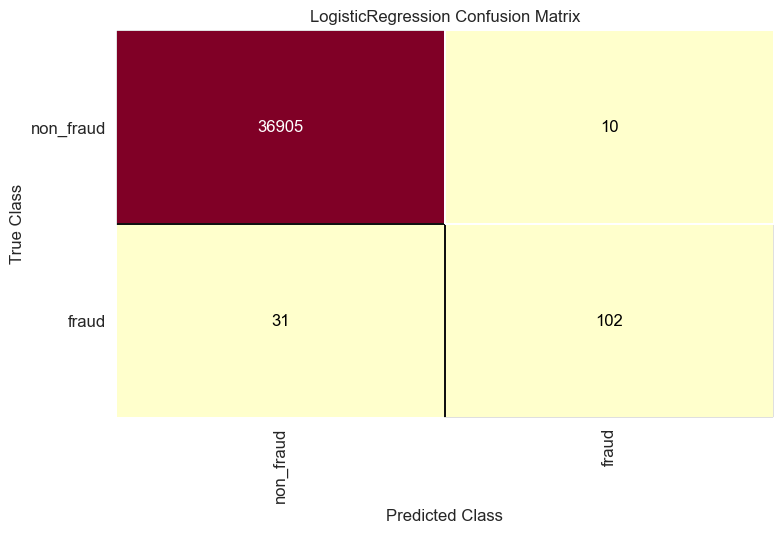

In [56]:
# split data into training and testing:
x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# fit model with same parameters and random state:
logistic_regression_model.fit(x_train_resampled, y_train_resampled)

# Predict on test data:
y_predict_resampled = logistic_regression_model.predict(x_test_resampled)

# classification report:
print(classification_report(y_test_resampled, y_predict_resampled))


get_ConfusionMatrix(logistic_regression_model, x_train_resampled, y_train_resampled, x_test_resampled, y_test_resampled)

### Observations:
- Fitting simple statistical linear model shows significant features that forms a good predictors of fraud class, V4,V8,V10,V13,V14,V20,V21,V22 and V27.
- Pseudo R-squ: 0.6922 shows that the model is a average fit for the data.
- Logistic regression model is a good baseline model for this dataset, with recall 0.63 for fraud class, we want to capture fraud cases as much as possible.
- Overall F1-score is 0.87, which is a good score for a baseline model but still what is relevant is the F1-score for fraud class since the data is heavily imbalanced.
- The learning curve for 5-fold cross validation shows that the model is not over-fitting.
- Most important features are V22,V4,V21,V5,V26,V1,V24,V12,V19,V18, Amount and Time almost has not affect on fraud class.
- ROC-AUC curve shows that the model is a good fit for the data but still irrelevant since the data is imbalanced.
- Model predicted 86 fraud transaction or the true-positive and missed 50 fraud transaction or the false-negative.
- Most important insight to highlight is probability threshold for predicting class fraud is 0.10, if we suspect with low probability if the model is fraud we can investigate further.
- Feature selection with elimination method resulting in 15 features increases the fraud detection by 1 only from 86 to 87.
- Under-sampling the majority class "Non-Fraud" to 0.4% of the data, increases the fraud detection from 87 to 102 but still we might risk losing information from the original distribution of the data we can not take such decision without further domain knowledge about the meaning of the variables introduced in the data.


## Complex Model:
###### Where we increase the complexity of the model by using ensemble methods:

In [59]:
# Set the scale_pos_weight parameter:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Create a LightGBM dataset object
dtrain = lgb.Dataset(x_train, label=y_train)

# Set the hyper-parameters help us approach the imbalanced data:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'scale_pos_weight': scale_pos_weight,

}

lightgbm_model = LGBMClassifier(
                              # **params,verbose=100,
    # n_estimators=len(X.columns),
    # is_unbalance=True,
    num_leaves=100,
    max_depth=100,
    # learning_rate=0.001,
    )

# Train the model
lightgbm_model.fit(x_train, y_train)

# Make predictions on the validation set
y_pred = lightgbm_model.predict(x_test)

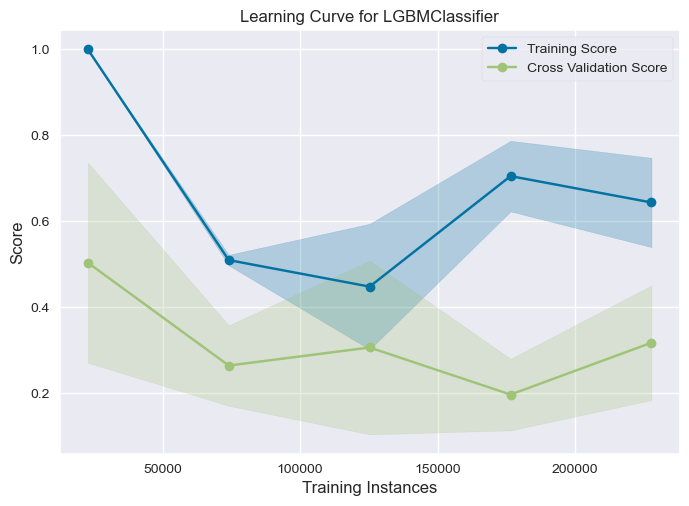

In [58]:
ge_learning_curve(lightgbm_model, X, y, cv=5, scoring='f1')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.81      0.82      0.82       136

    accuracy                           1.00     85443
   macro avg       0.91      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443



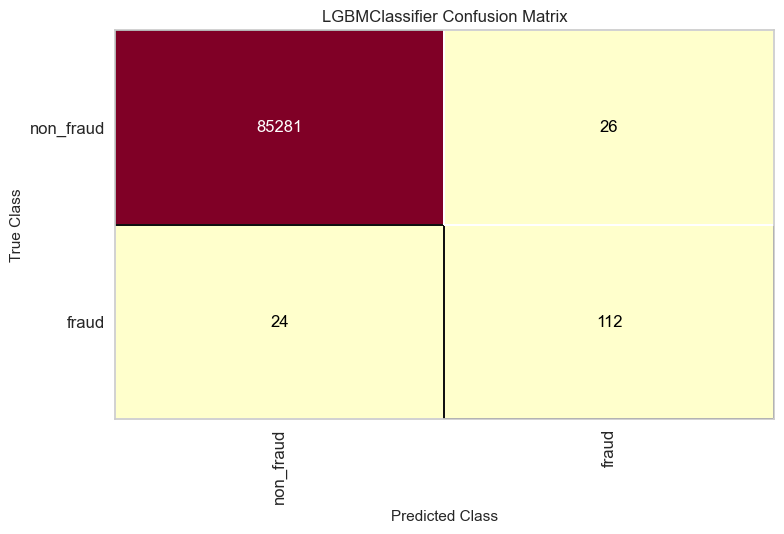

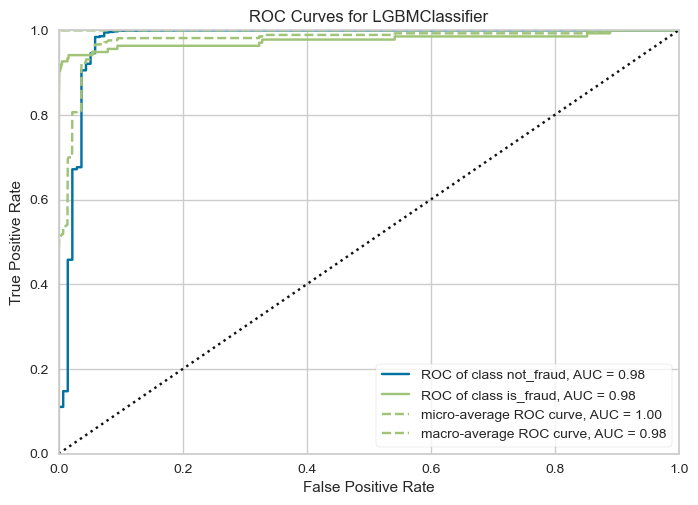

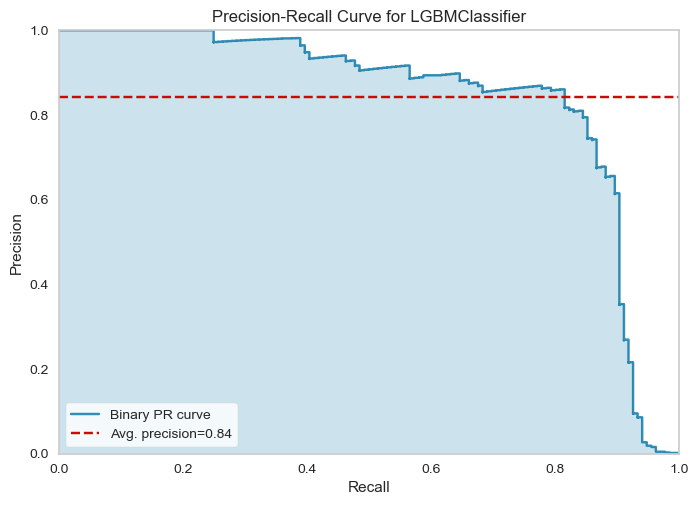

In [41]:
print(classification_report(y_test, y_pred))

get_ConfusionMatrix(lightgbm_model, x_train, y_train, x_test, y_test)

feature_importance_plot(lightgbm_model.feature_importances_, x_train.columns.tolist())

get_ROCAUC(lightgbm_model, x_train, y_train, x_test, y_test, classes=["not_fraud", "is_fraud"])

get_PrecisionRecallCurve(lightgbm_model, x_train, y_train, x_test, y_test)

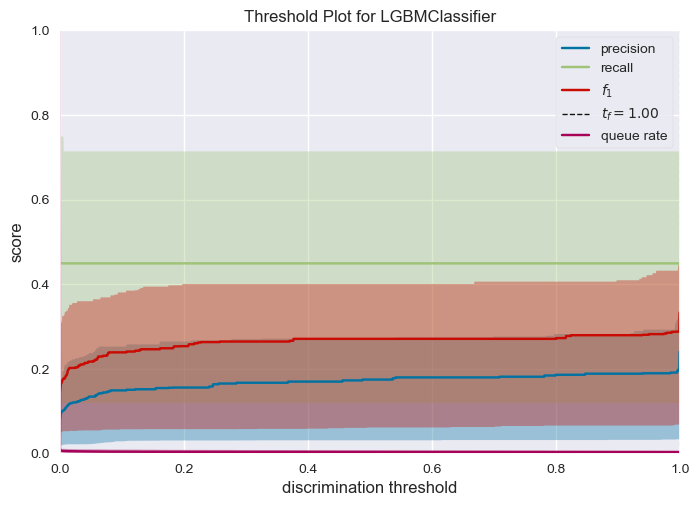

In [60]:
lightgbm_model_test = LGBMClassifier()
get_DiscriminationThreshold(lightgbm_model_test, x_test, y_test)

### Observations:
- Lightgbm model is able to capture more fraud transactions with F1 score of 0.82.
- Learning curve shows the model is unstable over 5-fold cross validation, it comes from the fact that the data is imbalanced.
- Frauds detection increase to 112 from 87 without under-sampling the majority class.
- Deciding a threshold for is difficult for lightgbm it's the case generally for boosting models, they do not offer a well calibrated probability as compared to logistic regression.

In [61]:
lightgbm_model.fit(X_resampled, y_resampled)
calibrated_clf = CalibratedClassifierCV(lightgbm_model, cv='prefit', method='sigmoid')
calibrated_clf.fit(X_resampled, y_resampled)

CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(max_depth=100, num_leaves=100))

In [62]:
final_results = X_resampled.copy()
final_results['y'] = y_resampled
final_results['probability_fraud'] = calibrated_clf.predict_proba(X_resampled)[:, 1]
final_results['probability_non_fraud'] = calibrated_clf.predict_proba(X_resampled)[:, 0]
final_results['probability_fraud_logi'] = logistic_regression_model.predict_proba(X_resampled)[:, 1]
final_results['probability_non_fraud_logi'] = logistic_regression_model.predict_proba(X_resampled)[:, 0]

In [63]:
frauds_indexes = y_resampled.loc[y_resampled == 1].index
X_resampled_fraud = X_resampled.loc[frauds_indexes]
frauds_indexes_list = frauds_indexes.tolist()

# Explainable AI
Where we explain the model predictions performed by lightgbm model:

In [64]:
shap.initjs()
explainer = shap.TreeExplainer(lightgbm_model)
shap_values = explainer.shap_values(X_resampled, y_resampled, check_additivity=False)

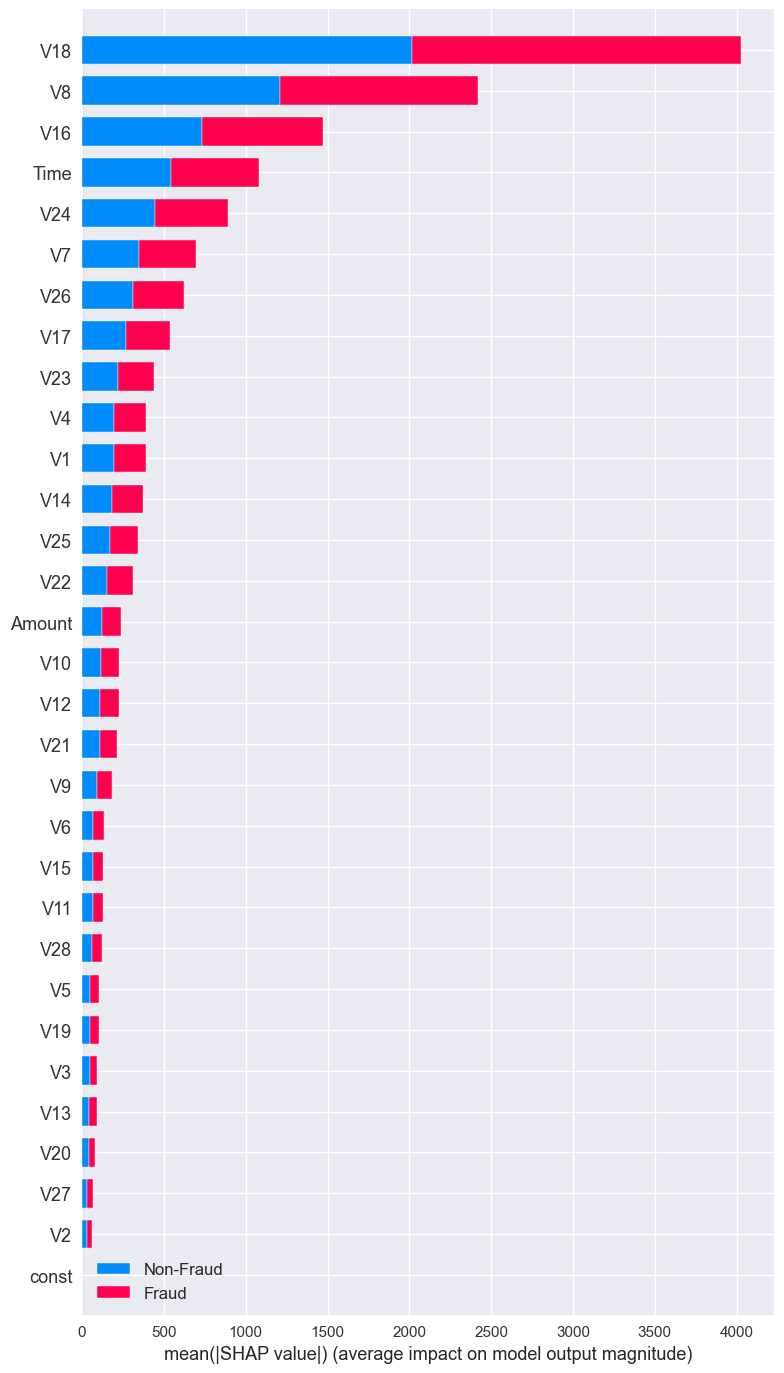

In [65]:
shap.summary_plot(shap_values, X_resampled, max_display=len(X.index),class_names=['Non-Fraud', 'Fraud'])

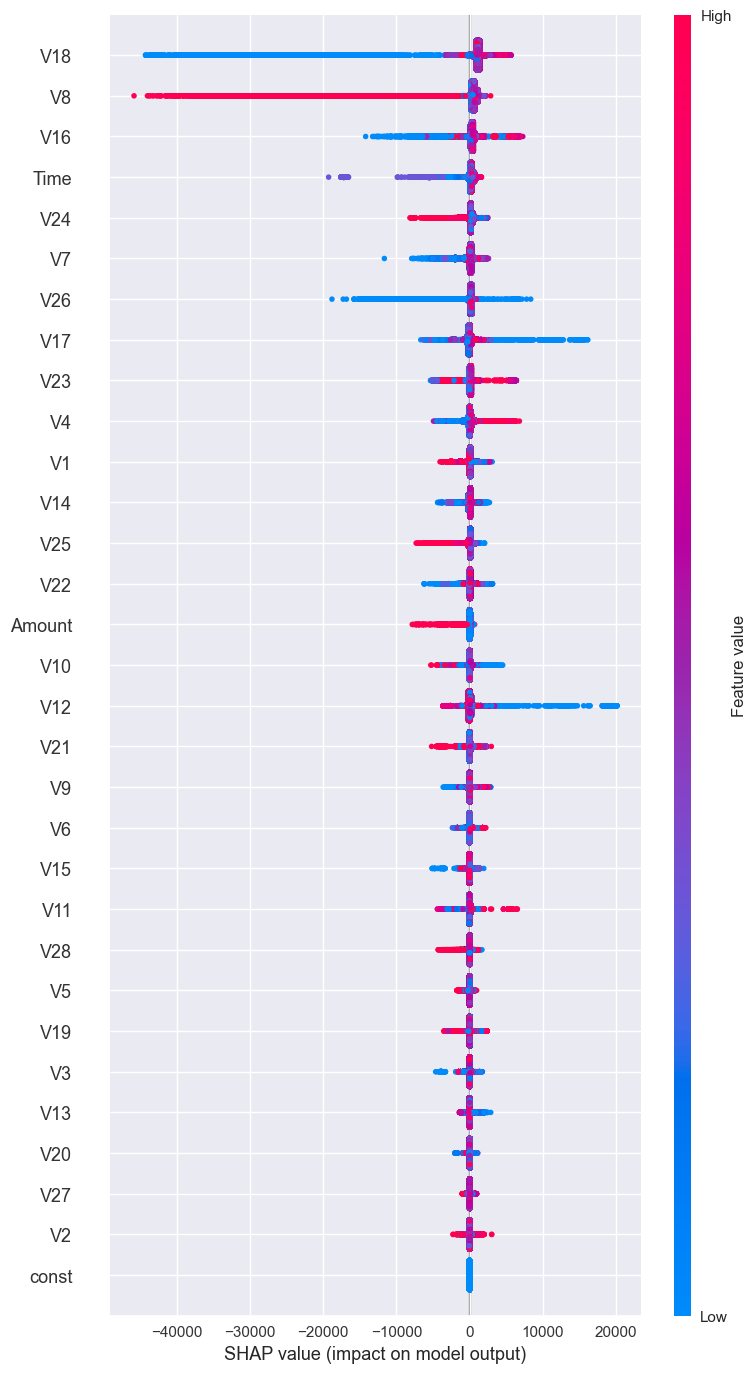

In [66]:
# impact of Fraud on the model:
shap.summary_plot(shap_values[1],
                  X_resampled,
                  max_display=len(X_resampled.index),
                  class_names=['Non-Fraud', 'Fraud'])

###### Interaction between most impactful features for Fraud transactions:

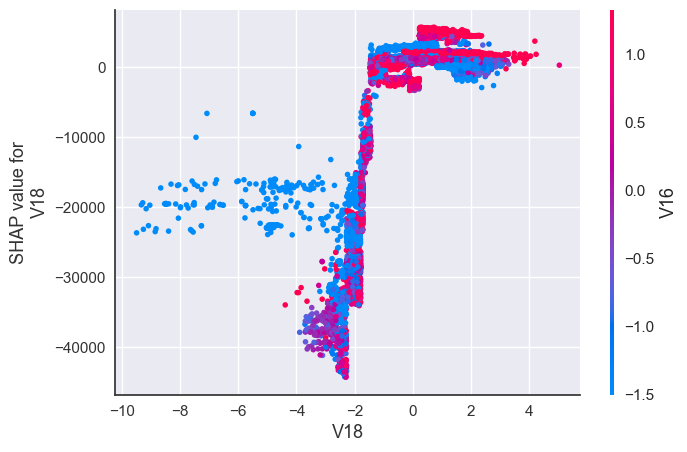

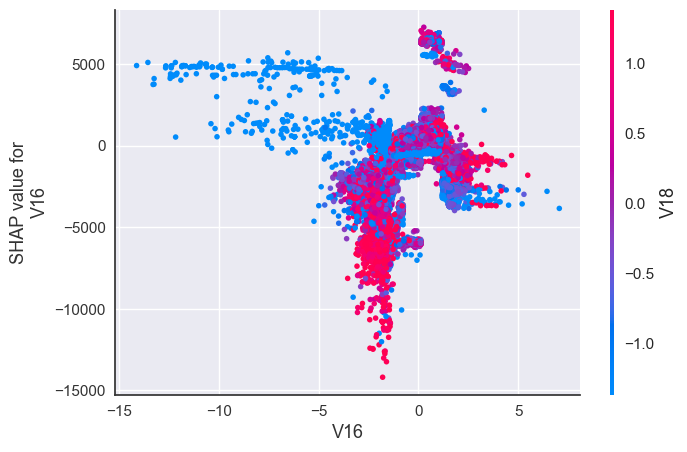

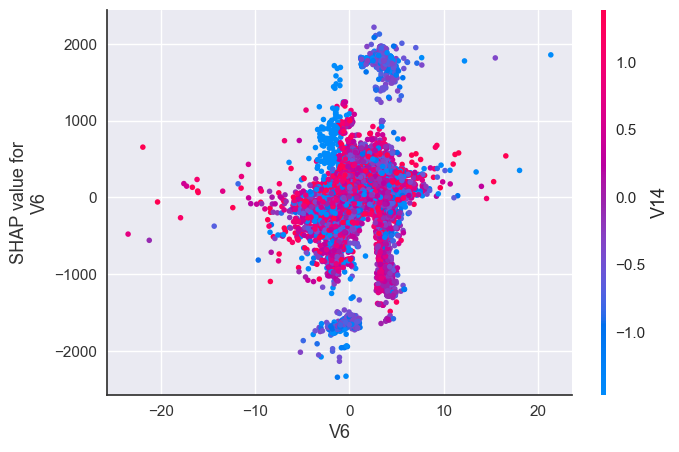

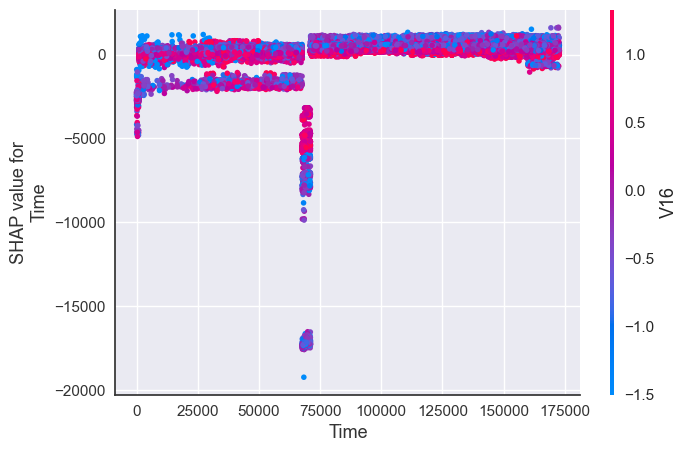

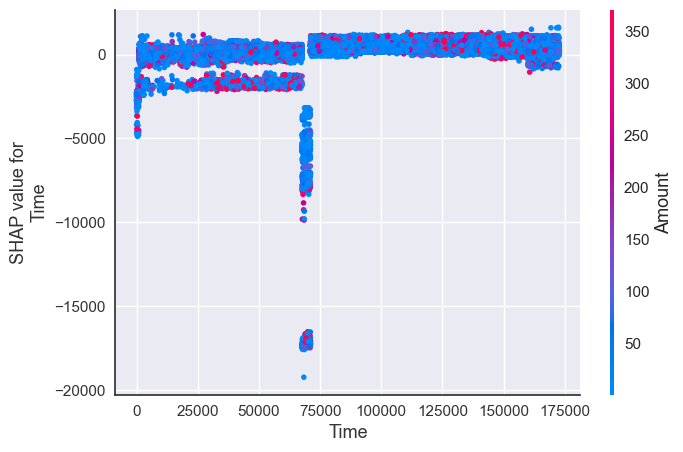

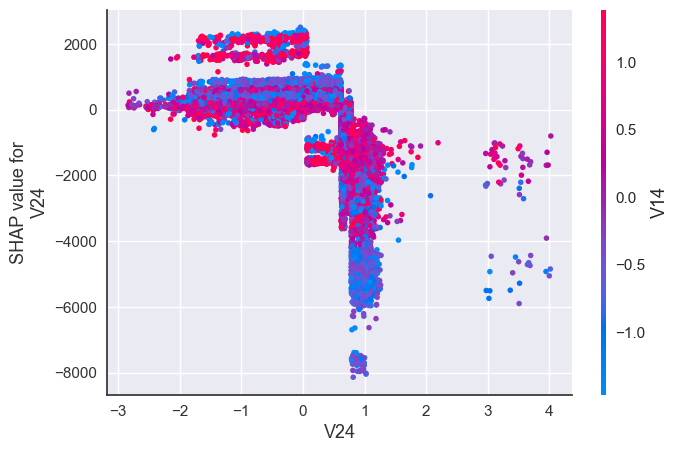

In [67]:
shap.dependence_plot("V18", shap_values[1], X_resampled)

shap.dependence_plot("V16", shap_values[1], X_resampled)

shap.dependence_plot("V6", shap_values[1], X_resampled)

shap.dependence_plot("Time", shap_values[1], X_resampled)

shap.dependence_plot("Time", shap_values[1], X_resampled, interaction_index="Amount")

shap.dependence_plot("V24", shap_values[1], X_resampled)

###### Local Explanations of randomly chosen frauds transactions:

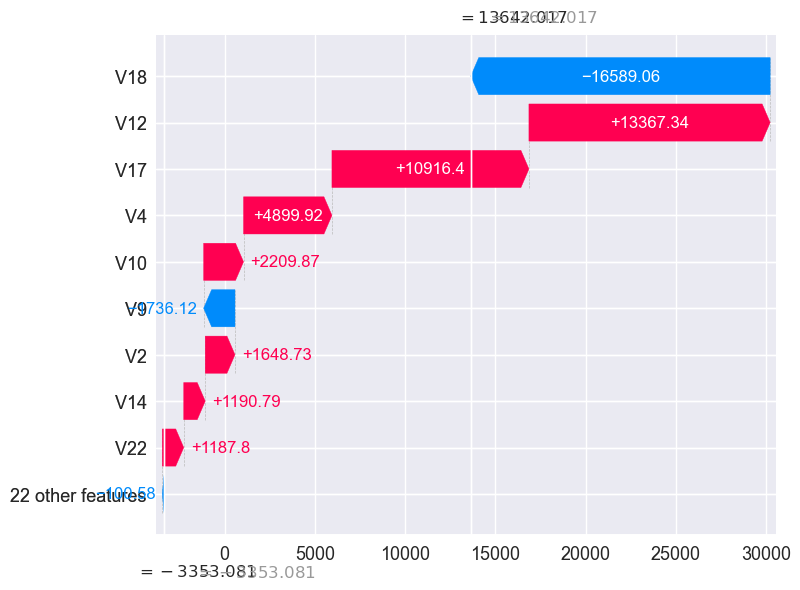

const                         1.000000e+00
Time                          1.839900e+04
V1                           -1.447444e+01
V2                            6.503185e+00
V3                           -1.771263e+01
V4                            1.127035e+01
V5                           -4.150142e+00
V6                           -3.372098e+00
V7                           -1.653581e+01
V8                           -1.443947e+00
V9                           -6.815273e+00
V10                          -1.367055e+01
V11                           1.054526e+01
V12                          -1.502270e+01
V13                           1.716331e-01
V14                          -1.506637e+01
V15                          -2.595759e-01
V16                          -8.668739e+00
V17                          -1.280414e+01
V18                          -5.116620e+00
V19                           5.792004e-01
V20                           1.101250e+00
V21                          -2.475962e+00
V22        

In [68]:
choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)


final_results.loc[choose_random_fraud]

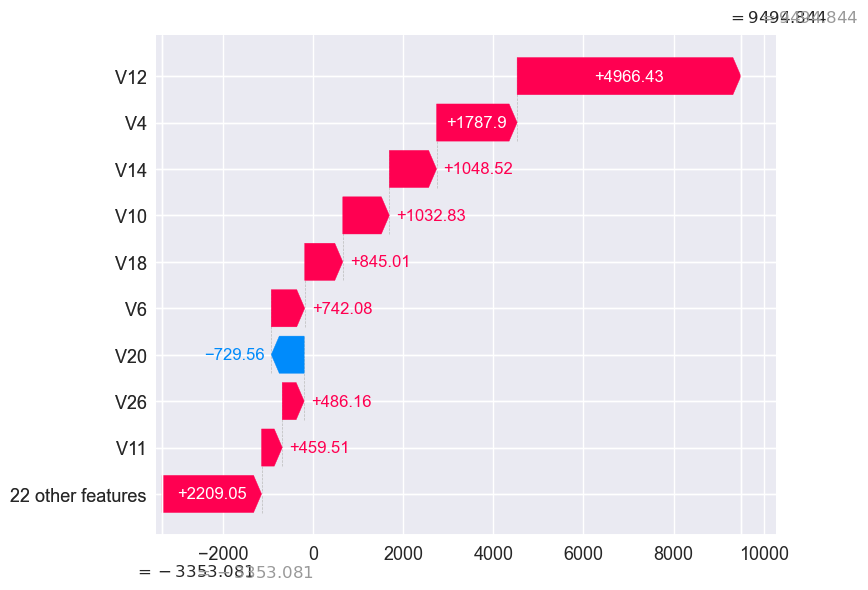

const                             1.000000
Time                          42474.000000
V1                               -3.843009
V2                                3.375110
V3                               -5.492893
V4                                6.136378
V5                                2.797195
V6                               -2.646162
V7                               -1.668931
V8                               -2.617552
V9                               -3.945843
V10                              -4.565252
V11                               4.097216
V12                              -5.450916
V13                              -0.965693
V14                             -10.904459
V15                               0.526948
V16                              -1.139754
V17                               0.835640
V18                               0.389774
V19                              -1.439608
V20                               0.054796
V21                              -1.277812
V22        

In [69]:
choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)



final_results.loc[choose_random_fraud]

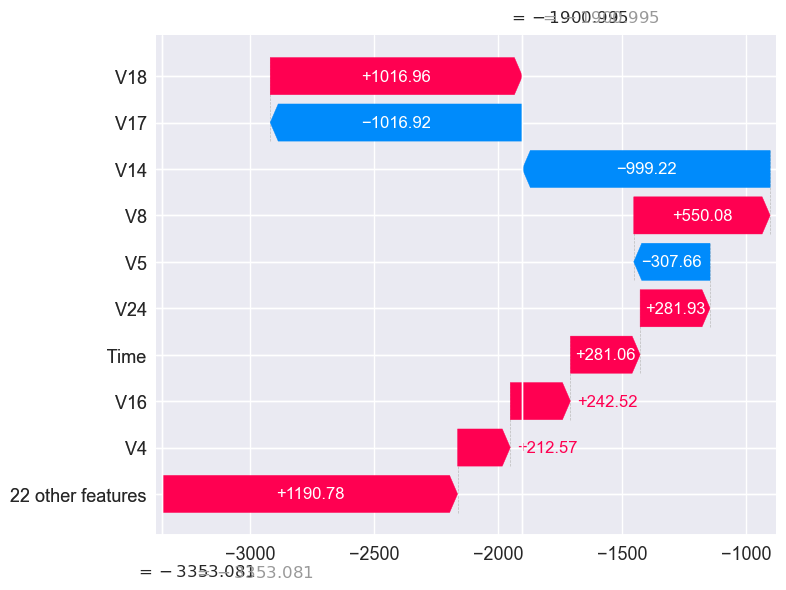

const                              1.000000
Time                          142280.000000
V1                                -1.169203
V2                                 1.863414
V3                                -2.515135
V4                                 5.463681
V5                                -0.297971
V6                                 1.364918
V7                                 0.759219
V8                                -0.118861
V9                                -2.293921
V10                               -0.423784
V11                                2.375876
V12                               -3.244827
V13                               -0.556619
V14                               -5.152475
V15                                0.050906
V16                               -1.022045
V17                               -1.646505
V18                                0.126460
V19                                1.819013
V20                               -0.299374
V21                             

In [70]:
choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)

final_results.loc[choose_random_fraud]

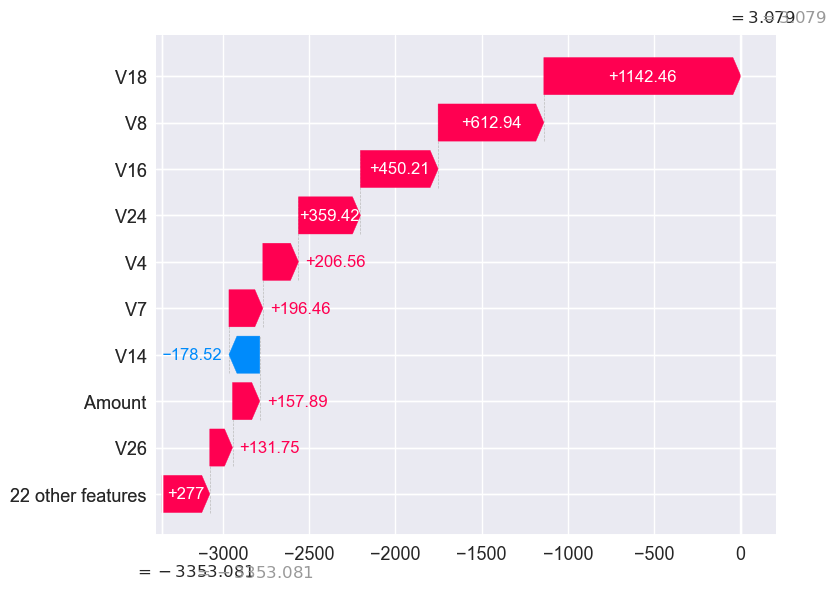

const                             1.000000
Time                          45501.000000
V1                                1.001992
V2                                0.047938
V3                               -0.349002
V4                                1.493958
V5                                0.186939
V6                                0.190966
V7                               -0.001112
V8                                0.147140
V9                                0.580415
V10                              -0.792938
V11                              -0.984172
V12                              -0.567380
V13                              -1.105592
V14                              -1.381214
V15                               0.405490
V16                               0.279890
V17                               1.132160
V18                               0.092993
V19                              -0.298920
V20                               0.016004
V21                              -0.334417
V22        

In [71]:
choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)


final_results.loc[choose_random_fraud]

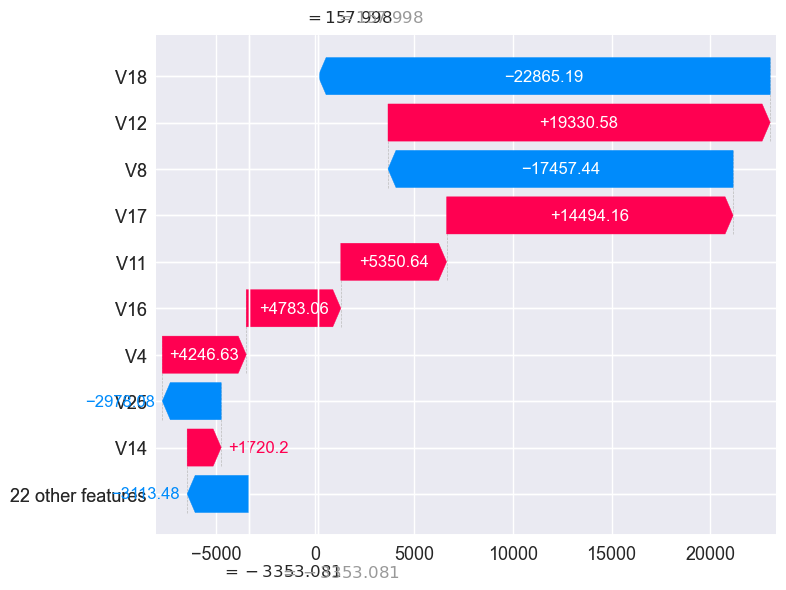

const                             1.000000
Time                          25254.000000
V1                              -17.275191
V2                               10.819665
V3                              -20.363886
V4                                6.046612
V5                              -13.465033
V6                               -4.166647
V7                              -14.409448
V8                               11.580797
V9                               -4.073856
V10                              -9.153368
V11                               6.210883
V12                              -8.778572
V13                              -0.061367
V14                              -9.574662
V15                               0.049289
V16                              -7.418487
V17                             -14.102772
V18                              -5.016423
V19                               1.390314
V20                               1.544970
V21                               1.729804
V22        

In [72]:
choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)

final_results.loc[choose_random_fraud]

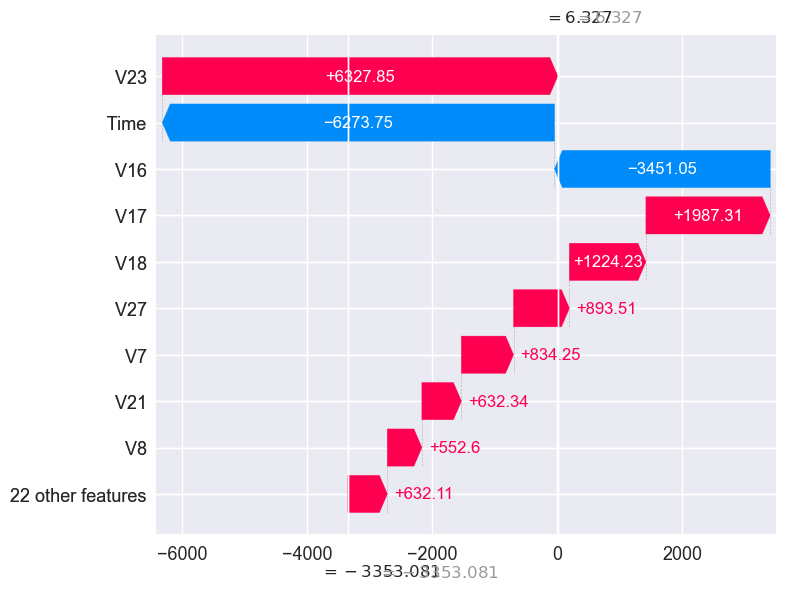

const                             1.000000
Time                          68357.000000
V1                                1.232604
V2                               -0.548931
V3                                1.087873
V4                                0.894082
V5                               -1.433055
V6                               -0.356797
V7                               -0.717492
V8                                0.003167
V9                               -0.100397
V10                               0.543187
V11                              -1.039417
V12                               0.285262
V13                              -0.206007
V14                              -0.498522
V15                              -1.064108
V16                              -2.156037
V17                               0.564761
V18                               0.837857
V19                              -0.728990
V20                              -0.576274
V21                              -0.448671
V22        

In [73]:
choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)

final_results.loc[choose_random_fraud]

### Insight from real values and Explainable AI values:

###### Prepare the data first:

In [74]:
# Slice by fraud transactions:
fraud_final_results = final_results[final_results["y"] == 1]

# validate that we are dealing with fraud transactions only:
fraud_final_results.index.equals(frauds_indexes)

# get shap values of fraud transactions only, 1 here refers to fraud transaction or label:
shap_values_fraud = shap_values[1][fraud_final_results.index]

shap_values_fraud = pd.DataFrame(shap_values_fraud, columns=X_resampled.columns)
shap_values_fraud.drop(columns=['const'], inplace=True,errors='ignore')
fraud_final_results.drop(columns=['const'], inplace=True,errors='ignore')

list_columns = shap_values_fraud.columns.tolist()
new_columns = [column + "_shap" for column in list_columns]
shap_values_fraud.columns = new_columns

# to make sure we are dealing with the same indexes, and help us merge the dataframes:
fraud_final_results = fraud_final_results.reset_index()
shap_values_fraud["index"] = fraud_final_results["index"]
overall_final  = fraud_final_results.merge(shap_values_fraud, on="index")

In [75]:
overall_final["probability_fraud"] = overall_final["probability_fraud"].apply(lambda x: round(x, 4))
overall_final["probability_fraud"] = overall_final["probability_fraud"].astype(float)

In [76]:
# shap values should be in the positive range, it means its effecting fraud probability positively:
mean_series = overall_final.mean(axis=0)
mean_series = mean_series.sort_values(ascending=False)
mean_series

index       123245.500000
Time         80746.806911
V17_shap      8510.094384
V12_shap      8293.768162
V4_shap       2224.738310
                ...      
V9_shap       -390.242928
V19_shap      -448.767418
V7_shap       -555.546820
V8_shap      -3842.413947
V18_shap     -9396.813096
Length: 66, dtype: float64

[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V7')]

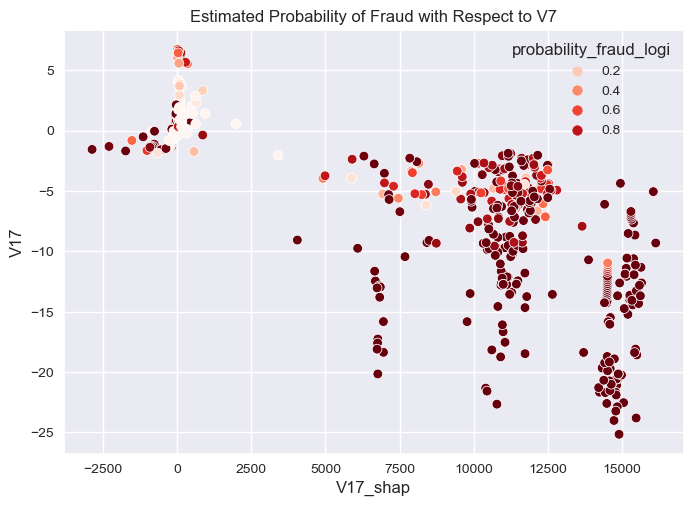

In [77]:
sns.scatterplot(overall_final,
                y="V17",
                x="V17_shap",
                hue="probability_fraud_logi",
                palette="Reds"
             ).set(title="Estimated Probability of Fraud with Respect to V7")

[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V12')]

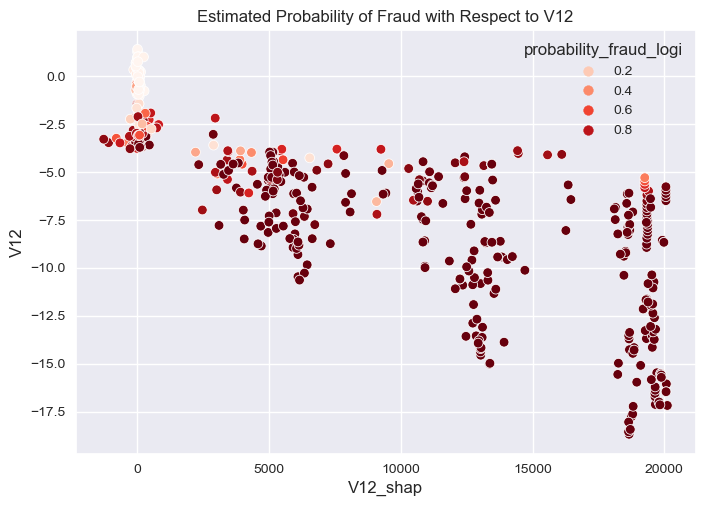

In [78]:
sns.scatterplot(overall_final,
                y="V12",
                x="V12_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to V12")

[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V4')]

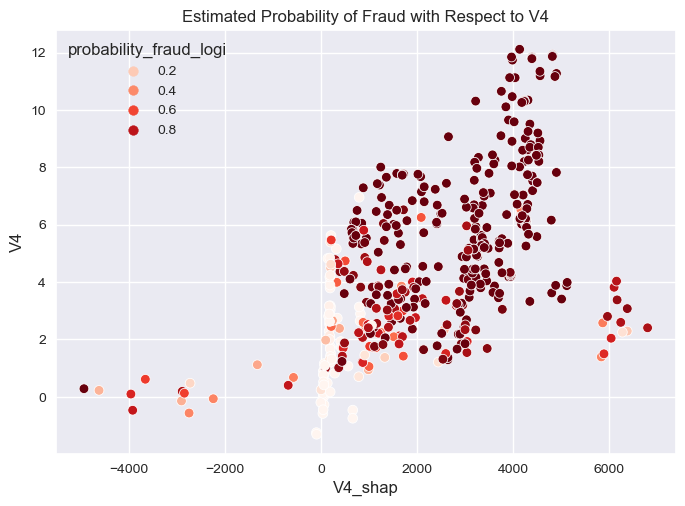

In [79]:
sns.scatterplot(overall_final,
                y="V4",
                x="V4_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to V4")

[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V10')]

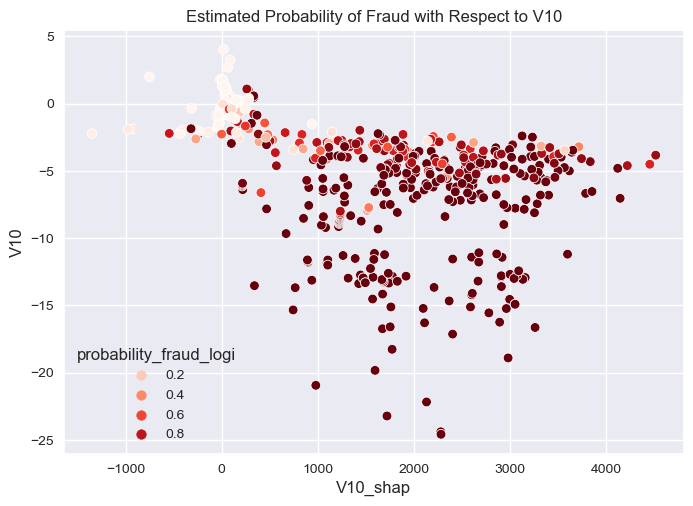

In [80]:
sns.scatterplot(overall_final,
                y="V10",
                x="V10_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to V10")

[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V11')]

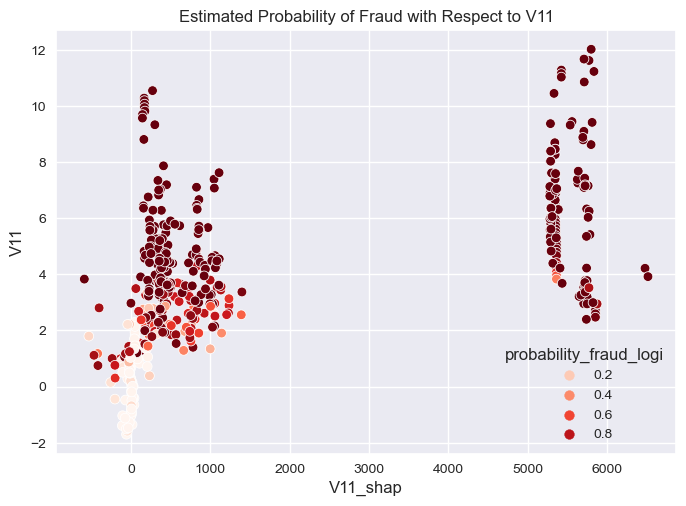

In [81]:
sns.scatterplot(overall_final,
                y="V11",
                x="V11_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to V11")

[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to Time')]

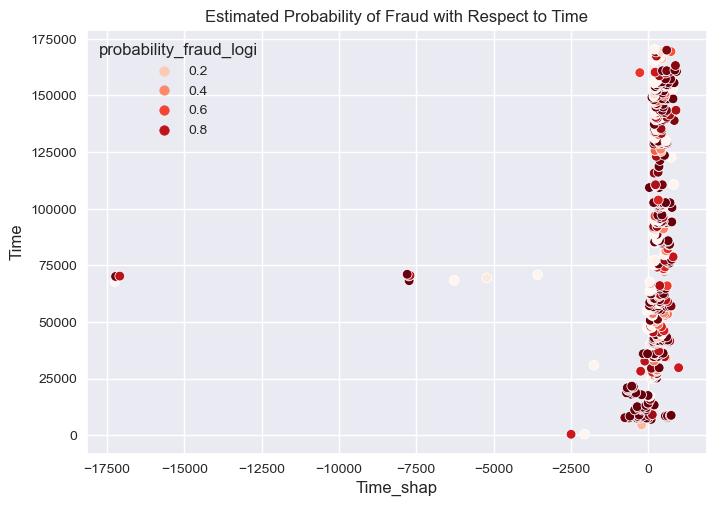

In [82]:
sns.scatterplot(overall_final,
                y="Time",
                x="Time_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to Time")

[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to Time')]

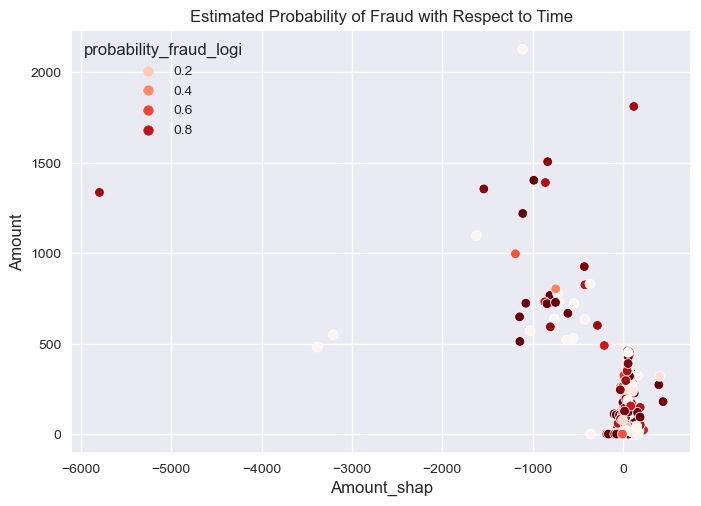

In [83]:
sns.scatterplot(overall_final,
                y="Amount",
                x="Amount_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to Time")

### Observations
- Features V18,V8,V16,TIME and V7 has the most impact on the probability of fraud.
- The lower the value of V18 the lower the probability of fraud almost most fraud transactions predicted fraud influenced by lower value of V18.
- The higher the value of V8 the lower the probability of fraud, second-largest impact on the probability of fraud.
- The higher the value of V4 and V23 the higher the probability of fraud.
- The higher the amount of transaction the lower the probability of fraud but few example are predicted fraud impacted by amount feature.
- I sampled few examples that predicted as fraud and explained them locally with V12 and V17 pushed the prediction toward fraud with higher magnitude from the expected value of fraud, interestingly the opposite happened with 12 pushed the prediction toward non-fraud with higher magnitude from the expected value of non-fraud.
- Interestingly when visualizing the actual values of most impacted features that influences the probability of fraud we can see that:
    - We can easily decide fraud transaction with high probability of fraud with V17 and V12 actual value being less than -5 with high shap values impact greater than 5K magnitude from the base value.
    - The higher V4 the higher the impact of the model in predicting fraud.
    - The higher value of V11 when its values is positive integer and greater or equal to 3 the higher the impact of the model in predicting fraud.
    - Time of the transaction almost has no effect in distinguishing fraud transactions from non-fraud transactions.

# Conclusion, discussion  and Actionable Insights:


- The goal is to detect fraud from a series of transactions, the problem is very challenging as the data is highly imbalanced, tho I have came up with actionable insight from the data after investigating it and building multiple models and comparing them, the first actionable insight is of course is related to how certain we are in detecting fraud from population of transactions, we now logist regression model is efficient in its probability calibration so it outputs well calibrated probability output for this reason I have chosen this model to decide weather a transaction is a fraud or not based on the probability output, unsurprisingly the probability threshold is 0.1, so if the probability of a transaction being a fraud is greater or equal to 0.1 then we will consider it as a fraud.
- The second actionable insight is related to the features that are most important in detecting fraud, the lower the value of V18 the lower the probability of fraud almost most fraud transactions predicted fraud influenced by lower value of V18.
- thirdly interstage transaction that has higher the value of V8 which lower the probability of fraud.
-  We can easily decide fraud transaction with high probability of fraud with V17 and V12 actual value being less than -5 with high shap values impact greater than 5K magnitude from the base value.
- The higher V4 the higher the impact of the model in predicting fraud.
- The higher value of V11 when its values is positive integer and greater or equal to 3 the higher the impact of the model in predicting fraud.
- Time of the transaction almost has no effect in distinguishing fraud transactions from non-fraud transactions.





